<a href="https://colab.research.google.com/github/tajerian/ham10000-app/blob/main/skin_cancer_Ham10000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing the essential libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import random
print(f'TensorFlow version: {tf.__version__}')
print(f'\nAccessible devices: \n{(tf.config.list_physical_devices())}')

TensorFlow version: 2.9.2

Accessible devices: 
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#Check GPU & its compute capability

In [ ]:
!nvidia-smi 

Wed Jan 11 20:48:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
print(f'is GPU built with cuda: {tf.test.is_built_with_cuda()}')
print(f'is compute capability at least 7.0: {tf.test.is_gpu_available(True, (7,0))}')

In [ ]:
#You can see the disk information using a command like !df -h. 
#To see CPU specs, !cat /proc/cpuinfo
!cat /proc/cpuinfo
#For memory, !cat /proc/meminfo.
!cat /proc/meminfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2299.998
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs mmio_stale_data retbleed
bogomips	: 4599.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtua

In [ ]:
pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Get helper functions file
import os 

if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")

--2023-01-10 21:31:21--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-10 21:31:21 (106 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys, load_and_prep_image

#Downloading ham10000 dataset using kaggle API

In [ ]:
# First go to your Kaggle account and create New API Token, a kaggle.json file will be download.

# Make sure you have a kaggle.json file.
!ls -lha kaggle.json

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

# You must change "kmader/skin-cancer-mnist-ham10000" with the dataset you want.
# You can use copy API command from kaggle to be sure
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

# Unzip data in Google Colab
!unzip -q /content/skin-cancer-mnist-ham10000.zip -d dataset

# Unzip data in Google Drive
#!unzip -q /content/skin-cancer-mnist-ham10000.zip -d '/content/gdrive/My Drive/ML data'

#What is in the Kaggle skin-cancer-mnist-ham10000 data?
the *skin-cancer-mnist-ham10000.zip* file downled from kaggle contains HAM10000_images_part_1 with 5000 unlabled (450, 600, 3)images, HAM10000_images_part_2 with 5015 unlabled (450, 600, 3)images and a HAM10000_metadata csv file witch contains diagnosis for each image file in these two floders.
<br>***here you can see HAM10000_metadata.csv:***</br>







In [ ]:
x=pd.read_csv("/content/dataset/HAM10000_metadata.csv")
x.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [ ]:
n=np.asarray(x)
n=n[:,1:3]
n[:,0]=n[:,0]+'.jpg'
print(n.shape)
print(n[0])

(10015, 2)
['ISIC_0027419.jpg' 'bkl']


#labeling the images
TensorFlow APIs like tf.keras.preprocessing.image_dataset_from_directory or tensorflow.keras.preprocessing.image.ImageDataGenerator are commonly used to Generate batches of tensor image data with real-time data augmentation and these batches contain both image tenseros and one hot encoded lables together in a tuple.

> 🔑note: when you are going to fit the model by Train_Data Generated with ImageDataGenerator API as both image tenseros and lables are together in a tuple and Train_Data=(X_train, y_train), therefore model.fit(Train_Data,...) is used instead of model.fit(X=train_images,y=train_labels,...)

<br>ImageDataGenerator and image_dataset_from_directory APIs needs images of different classes to be in different folders and they label them based on alphabetic order of the each class folder.</br>
<br>***here we are going to move each image to its class folder:***</br>



In [ ]:
all_images_dir='/content/ham10000'
os.mkdir(all_images_dir)

In [ ]:
train_images_dir='/content/ham10000/train'
os.mkdir(train_images_dir)

In [ ]:
train_images_dir='/content/ham10000/train/vasc'
os.mkdir(train_images_dir)
train_images_dir='/content/ham10000/train/bkl'
os.mkdir(train_images_dir)
train_images_dir='/content/ham10000/train/df'
os.mkdir(train_images_dir)
train_images_dir='/content/ham10000/train/bcc'
os.mkdir(train_images_dir)
train_images_dir='/content/ham10000/train/akiec'
os.mkdir(train_images_dir)
train_images_dir='/content/ham10000/train/mel'
os.mkdir(train_images_dir)
train_images_dir='/content/ham10000/train/nv'
os.mkdir(train_images_dir)

In [ ]:
test_images_dir='/content/ham10000/test'
os.mkdir(test_images_dir)

In [ ]:
test_images_dir='/content/ham10000/test/vasc'
os.mkdir(test_images_dir)
test_images_dir='/content/ham10000/test/bkl'
os.mkdir(test_images_dir)
test_images_dir='/content/ham10000/test/df'
os.mkdir(test_images_dir)
test_images_dir='/content/ham10000/test/bcc'
os.mkdir(test_images_dir)
test_images_dir='/content/ham10000/test/akiec'
os.mkdir(test_images_dir)
test_images_dir='/content/ham10000/test/mel'
os.mkdir(test_images_dir)
test_images_dir='/content/ham10000/test/nv'
os.mkdir(test_images_dir)

In [ ]:
import shutil
i=0

for file_name in os.listdir('/content/dataset/HAM10000_images_part_1'):
    if file_name[0] in ['I']:
    
        if file_name in  n[:,0]:
        
            print(file_name)
            i=i+1
            result = np.where(n[:,0] == file_name)
            
            print(file_name)
            result=result[0][0]
            
            pos=int(result)
            pos=n[pos,1]
            print(pos)
            
            current0='/content/dataset/HAM10000_images_part_1/'+file_name
            direc0='/content/ham10000/train/'+pos+'/'+file_name
                #print (im)
            shutil.move(current0,direc0 )
print(i)      

In [ ]:
import shutil
i=0

for file_name in os.listdir('/content/dataset/HAM10000_images_part_2'):
    if file_name[0] in ['I']:
    
        if file_name in  n[:,0]:
        
            print(file_name)
            i=i+1
            result = np.where(n[:,0] == file_name)
            
            print(file_name)
            result=result[0][0]
            
            pos=int(result)
            pos=n[pos,1]
            print(pos)
            
            current0='/content/dataset/HAM10000_images_part_2/'+file_name
            direc0='/content/ham10000/train/'+pos+'/'+file_name
                #print (im)
            shutil.move(current0,direc0 )
print(i)      

so as you see in the block below, from total 1015 images:

0.   327 images belonges to class akiec
1.   514 images belonges to class bcc
2.   1099 images belonges to class bkl
3.   115 images belonges to class df
4.   1113 images belonges to class mel
5.   6705 images belonges to class nv
6.   142 images belonges to class vasc

<br>***Now we need to split these images to Train and Test sets:***</br>




In [ ]:
class_names=sorted(os.listdir('/content/ham10000/train'))
for classes in class_names:
  print(f'number of images in class {classes} =',len(os.listdir('/content/ham10000/train/'+classes)))

number of images in class akiec = 327
number of images in class bcc = 514
number of images in class bkl = 1099
number of images in class df = 115
number of images in class mel = 1113
number of images in class nv = 6705
number of images in class vasc = 142


In [ ]:
i=0

for file_name in os.listdir('/content/ham10000/train'):
    
    
    
      if file_name in  n[:,1]:
        i=0
        m=[]
        direc=os.listdir('/content/ham10000/train/'+file_name)
        for j in range(int(.2*len(os.listdir('/content/ham10000/train/'+file_name)))):
          a=direc[j]
          direc.remove(a)
          m.append(a)
          i+=1
        for im in m:
          current0='/content/ham10000/train/'+file_name+'/'+im
          direc0=  '/content/ham10000/test/'+file_name+'/'+im
          shutil.move(current0,direc0)
          print(im,'is moved to test in class=',file_name)
        print(i)

#number of images in each class for test and train datasets

In [ ]:
for classes in class_names:
  print(f'number of images in class {classes} of train set =',len(os.listdir('/content/ham10000/train/'+classes)))

number of images in class akiec of train set = 262
number of images in class bcc of train set = 412
number of images in class bkl of train set = 880
number of images in class df of train set = 92
number of images in class mel of train set = 891
number of images in class nv of train set = 5364
number of images in class vasc of train set = 114


In [ ]:
for classes in class_names:
  print(f'number of images in class {classes} of test set =',len(os.listdir('/content/ham10000/test/'+classes)))

number of images in class akiec of test set = 65
number of images in class bcc of test set = 102
number of images in class bkl of test set = 219
number of images in class df of test set = 23
number of images in class mel of test set = 222
number of images in class nv of test set = 1341
number of images in class vasc of test set = 28


In [ ]:
# Import the required modules for model creation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, Dropout, Dense, MaxPool2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import layers
import datetime

#making functions to systematicly create,compile,fit,save and ploting models:

In [ ]:
def prepare_for_train_test(train_dir= '/content/ham10000/train',
                           test_dir= '/content/ham10000/test',
                           IMG_SIZE = (300, 400),
                           data_aug=False):
    if data_aug==False:
      print('no data augmentaion on train data....')
      train_datagen = ImageDataGenerator()
    if data_aug:
      print('using data augmentaion on train data....')
      train_datagen = ImageDataGenerator( rotation_range = 10,
                                          width_shift_range = 0.2,
                                          height_shift_range = 0.2,
                                          shear_range = 0.2,
                                          horizontal_flip = True,
                                          vertical_flip = True,
                                          fill_mode = 'nearest')
    train_data = train_datagen.flow_from_directory(directory=train_dir,
                                                   class_mode="categorical",
                                                   target_size=IMG_SIZE,
                                                   shuffle=False)
                                                                                    
    test_datagen = ImageDataGenerator()
    test_data = test_datagen.flow_from_directory(directory=test_dir,
                                              class_mode="categorical",
                                              target_size=IMG_SIZE,
                                              shuffle=False) # don't shuffle test data for prediction analysis


    
    return train_data, test_data

In [ ]:
transfer_model= 'EfficientNetB5'
exec('base_model = tf.keras.applications.'+transfer_model+'(include_top=False)')
base_model.trainable = False
def create_model(img_shape=(300,400), num_class=7):

    # Setup model architecture with trainable top layers
    inputs = layers.Input(shape=img_shape+(3,), name="input_layer") # shape of input image
    x = inputs   
    x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
    x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
    outputs = layers.Dense(num_class, activation="softmax", name="output_layer")(x) # same number of outputs as classes
    model = tf.keras.Model(inputs, outputs)

    model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])
    print(model.summary())
    return model;

115263384/115263384 [==============================] - 5s 0us/step


In [ ]:
def train_model(model, train_data, EPOCHS=5, experiment_name="efficientnetB0", directory='/content/drive/MyDrive/models/ham1000', fine_tune=False):
    early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, 
                           mode='auto')
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, 
                              verbose=1, mode='auto')
    # Create checkpoint callback to save model for later use
    checkpoint_path = "best_model"+experiment_name+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                            save_weights_only=True, # save only the model weights
                                                            monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                            save_best_only=True) # only keep the best model weights on file (delete the rest)
        
    if fine_tune==False:
      history = model.fit(train_data,
                          validation_data=test_data,
                          validation_steps= len(test_data),
                          epochs = EPOCHS,
                          callbacks = [reduce_lr,
                                      early_stop,
                                      create_tensorboard_callback(dir_name="/content/drive/MyDrive/tensor board log/ham10000_effi",experiment_name=experiment_name),
                                      checkpoint_callback])
    if fine_tune:
      history = model.fit(train_data,
                          validation_data=test_data,
                          validation_steps= len(test_data),
                          epochs = EPOCHS*2,
                          initial_epoch= EPOCHS-1,
                          callbacks = [reduce_lr,
                                      early_stop,
                                      create_tensorboard_callback(dir_name="/content/drive/MyDrive/tensor board log/ham10000_effi",experiment_name=experiment_name),
                                      checkpoint_callback],)
    os.mkdir(directory+'/'+experiment_name)
    model.save(directory+'/'+experiment_name+'/'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    return history


In [ ]:
def unfreeze(model, num_layers=10):
  """
  unfreeze top layers of the functional models to prepare them for fine tuning
  
  Parameters
  ----------
  model: tf.model obj
  num_layers(int): number of top layers of the base model to set them trainable.
  """
  # Unfreeze all of the layers in the base model
  base_model.trainable = True

  # Refreeze every layer except for the last 10
  for layer in base_model.layers[:-(num_layers)]:
    layer.trainable = False
  model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=.0001), # use Adam with default settings
                metrics=["accuracy"])
  print(model.summary())

#prepare for train_test data

In [ ]:
train_data, test_data = prepare_for_train_test(train_dir= '/content/ham10000/train',
                           test_dir= '/content/ham10000/test',
                           IMG_SIZE = (240, 240),
                           data_aug=False)
train_data_aug, test_data_aug = prepare_for_train_test(train_dir= '/content/ham10000/train',
                           test_dir= '/content/ham10000/test',
                           IMG_SIZE = (240, 240),
                           data_aug=True)

no data augmentaion on train data....
Found 8015 images belonging to 7 classes.
Found 2000 images belonging to 7 classes.
using data augmentaion on train data....
Found 8015 images belonging to 7 classes.
Found 2000 images belonging to 7 classes.


#How does our train data looks like:

In [ ]:

plt.figure(figsize=(20, 10))
for i in range(32):
  batch_num=random.randint(0,250)
  image_num=random.randint(0,31)
  plt.subplot(4, 8, i+1)
  plt.title(class_names[train_data[batch_num][1][image_num].argmax()])
  plt.imshow(train_data[batch_num][0][image_num]/255.);
  plt.axis(False)
plt.show()

And this is how augmented images looks like:

In [ ]:
plt.figure(figsize=(20, 10))
for i in range(32):
  batch_num=random.randint(0,250)
  image_num=random.randint(0,31)
  plt.subplot(4, 8, i+1)
  plt.title(class_names[train_data_aug[batch_num][1][image_num].argmax()])
  plt.imshow(train_data_aug[batch_num][0][image_num]/255.);
  plt.axis(False)
plt.show()

In [ ]:
def viso(data,dimention ):
  for i in range(dimention):
    a= data[dimention*i]
    for j in range (1,dimention):
      a=tf.concat([a, data[dimention*i+j]],1)
    if i ==0:img=a
    else:
      img= tf.concat([img,a],0)
  import plotly.express as px
  fig=px.imshow(img)
  fig.update_xaxes(visible=False)
  fig.update_yaxes(visible=False)
  fig.show()
  return img

In [ ]:
def vis(data,dimention ):
  for i in range(dimention):
    a= data[dimention*i]
    for j in range (1,dimention):
      a=tf.concat([a, data[dimention*i+j]],1)
    if i ==0:img=a
    else:
      img= tf.concat([img,a],0)
  return img[tf.newaxis,...]

In [ ]:
a=vis(train_data[100][0],3)


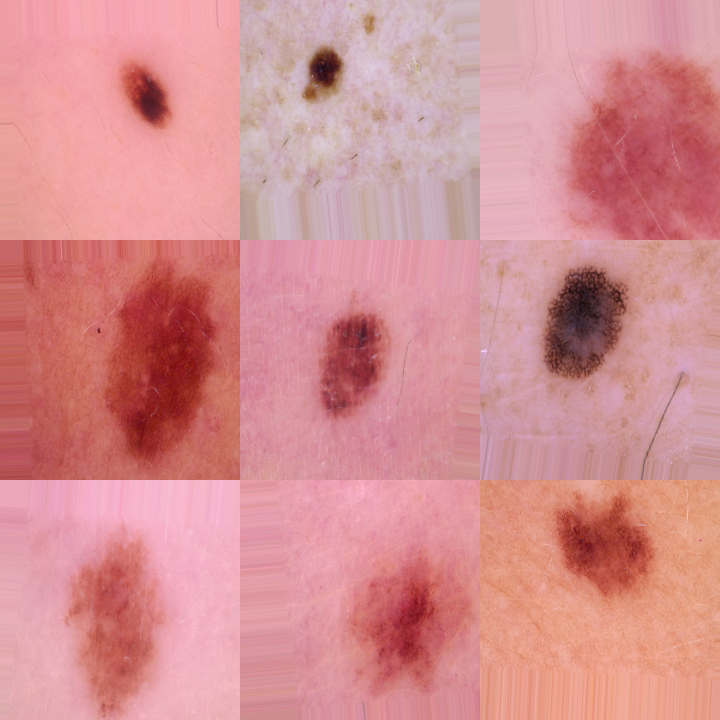

<tf.Tensor: shape=(720, 720, 3), dtype=float32, numpy=
array([[[238.     , 157.     , 164.     ],
        [238.     , 157.     , 164.     ],
        [238.     , 157.     , 164.     ],
        ...,
        [220.42018, 168.57982, 176.     ],
        [218.91379, 166.74828, 175.16551],
        [215.5857 , 162.51414, 173.17139]],

       [[238.     , 157.     , 164.     ],
        [238.     , 157.     , 164.     ],
        [238.     , 157.     , 164.     ],
        ...,
        [220.3415 , 168.6585 , 176.     ],
        [219.30713, 166.98428, 175.32285],
        [215.66437, 162.98616, 173.32872]],

       [[238.     , 157.     , 164.     ],
        [238.     , 157.     , 164.     ],
        [238.     , 157.     , 164.     ],
        ...,
        [220.26283, 168.73717, 176.     ],
        [219.70049, 167.22029, 175.4802 ],
        [215.74303, 163.45818, 173.48605]],

       ...,

       [[225.     , 170.     , 174.47165],
        [225.     , 170.     , 174.65373],
        [225.     , 170.   

In [ ]:
viso(train_data_aug[100][0],3)

In [ ]:
!pip install av

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 41.7 MB/s eta 0:00:00


In [ ]:
import torchvision
for i in range(600-67):
  b=vis(train_data_aug[100][0],3)
  a=tf.concat([a,b],axis=0)
torchvision.io.write_video('image_aug.mp4', a.numpy(),10)

In [ ]:
a.shape

TensorShape([601, 720, 720, 3])

#EfficientNetB0

##Feature extraction with out data augmentaion


In [ ]:
transfer_model= 'EfficientNetB0'
exec('base_model = tf.keras.applications.'+transfer_model+'(include_top=False)')
base_model.trainable = False
model_b0= create_model(img_shape=(450,600), num_class=7)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 450, 600, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 7)                 8967      
                                                                 
Total params: 4,058,538
Trainable params: 8,967
Non-trainable params: 4,049,571
_________________________________________________________________
None


Saving TensorBoard log files to: /content/drive/MyDrive/tensor board log/ham10000_effi/efficientnetB0/20221120-215609
Epoch 1/5
251/251 [==============================] - 157s 597ms/step - loss: 0.9031 - accuracy: 0.6881 - val_loss: 0.7742 - val_accuracy: 0.7190 - lr: 0.0010
Epoch 2/5
251/251 [==============================] - 154s 611ms/step - loss: 0.7355 - accuracy: 0.7342 - val_loss: 0.6977 - val_accuracy: 0.7560 - lr: 0.0010
Epoch 3/5
251/251 [==============================] - 143s 570ms/step - loss: 0.6780 - accuracy: 0.7580 - val_loss: 0.6611 - val_accuracy: 0.7575 - lr: 0.0010
Epoch 4/5
251/251 [==============================] - 140s 557ms/step - loss: 0.6387 - accuracy: 0.7708 - val_loss: 0.6276 - val_accuracy: 0.7820 - lr: 0.0010
Epoch 5/5
251/251 [==============================] - 141s 560ms/step - loss: 0.6117 - accuracy: 0.7780 - val_loss: 0.6162 - val_accuracy: 0.7865 - lr: 0.0010


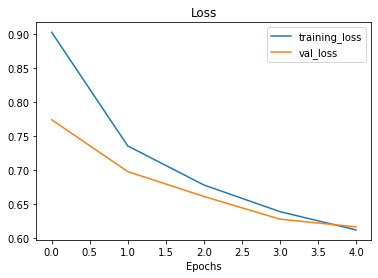

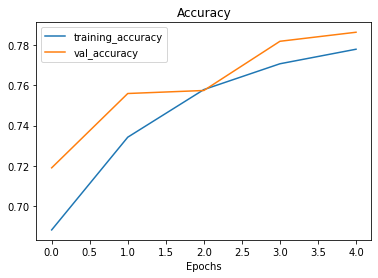

In [ ]:
history_b0= train_model(model_b0, train_data, experiment_name="efficientnetB0", EPOCHS=5)
plot_loss_curves(history_b0)

##FineTuning with out data augmentaion 

In [ ]:
unfreeze(model_b0, num_layers=10)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 450, 600, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 7)                 8967      
                                                                 
Total params: 4,058,538
Trainable params: 902,199
Non-trainable params: 3,156,339
_________________________________________________________________
None


Saving TensorBoard log files to: /content/drive/MyDrive/tensor board log/ham10000_effi/efficientnetB0_finetune/20221120-221142
Epoch 5/10
251/251 [==============================] - 157s 596ms/step - loss: 0.5692 - accuracy: 0.7885 - val_loss: 0.5630 - val_accuracy: 0.8035 - lr: 1.0000e-04
Epoch 6/10
251/251 [==============================] - 145s 576ms/step - loss: 0.5008 - accuracy: 0.8150 - val_loss: 0.5547 - val_accuracy: 0.7955 - lr: 1.0000e-04
Epoch 7/10
251/251 [==============================] - 145s 579ms/step - loss: 0.4549 - accuracy: 0.8361 - val_loss: 0.4954 - val_accuracy: 0.8340 - lr: 1.0000e-04
Epoch 8/10
251/251 [==============================] - 145s 576ms/step - loss: 0.4218 - accuracy: 0.8463 - val_loss: 0.4967 - val_accuracy: 0.8270 - lr: 1.0000e-04
Epoch 9/10
251/251 [==============================] - 158s 629ms/step - loss: 0.3927 - accuracy: 0.8608 - val_loss: 0.4626 - val_accuracy: 0.8470 - lr: 1.0000e-04
Epoch 10/10
251/251 [==============================] - 145

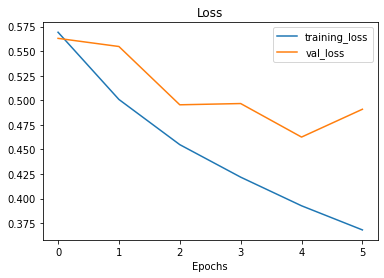

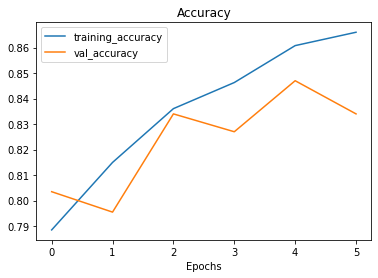

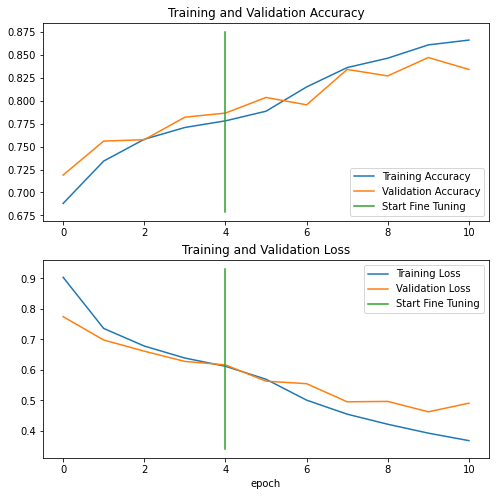

In [ ]:
history_b0_finetune= train_model(model_b0, train_data, experiment_name="efficientnetB0_finetune", EPOCHS=5, fine_tune=True)
plot_loss_curves(history_b0_finetune)
compare_historys(history_b0,
                 history_b0_finetune,
                 initial_epochs=5)

##Feature extraction with data augmentaion

In [ ]:
transfer_model= 'EfficientNetB0'
exec('base_model = tf.keras.applications.'+transfer_model+'(include_top=False)')
base_model.trainable = False
model_b0_aug= create_model(img_shape=(450,600), num_class=7)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 450, 600, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 7)                 8967      
                                                                 
Total params: 4,058,538
Trainable params: 8,967
Non-trainable params: 4,049,571
_________________________________________________________________
None


Saving TensorBoard log files to: /content/drive/MyDrive/tensor board log/ham10000_effi/efficientnetB0_aug/20221120-223252
Epoch 1/5
251/251 [==============================] - 540s 2s/step - loss: 0.9188 - accuracy: 0.6781 - val_loss: 0.8135 - val_accuracy: 0.7040 - lr: 0.0010
Epoch 2/5
251/251 [==============================] - 523s 2s/step - loss: 0.7577 - accuracy: 0.7239 - val_loss: 0.7216 - val_accuracy: 0.7460 - lr: 0.0010
Epoch 3/5
251/251 [==============================] - 531s 2s/step - loss: 0.7049 - accuracy: 0.7419 - val_loss: 0.6853 - val_accuracy: 0.7630 - lr: 0.0010
Epoch 4/5
251/251 [==============================] - 545s 2s/step - loss: 0.6678 - accuracy: 0.7626 - val_loss: 0.6503 - val_accuracy: 0.7765 - lr: 0.0010
Epoch 5/5
251/251 [==============================] - 518s 2s/step - loss: 0.6430 - accuracy: 0.7637 - val_loss: 0.6530 - val_accuracy: 0.7755 - lr: 0.0010


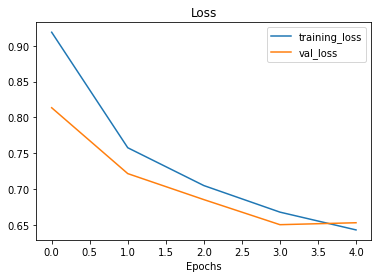

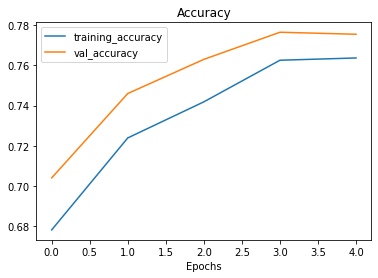

In [ ]:
history_b0_aug= train_model(model_b0_aug, train_data_aug, experiment_name="efficientnetB0_aug", EPOCHS=5)
plot_loss_curves(history_b0_aug)

##FineTuning with data augmentaion 

In [ ]:
unfreeze(model_b0_aug, num_layers=5)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 450, 600, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 7)                 8967      
                                                                 
Total params: 4,058,538
Trainable params: 790,407
Non-trainable params: 3,268,131
_________________________________________________________________
None


Saving TensorBoard log files to: /content/drive/MyDrive/tensor board log/ham10000_effi/efficientnetB0_aug_finetune/20221120-234013
Epoch 5/10
251/251 [==============================] - 538s 2s/step - loss: 0.6155 - accuracy: 0.7698 - val_loss: 0.6377 - val_accuracy: 0.7725 - lr: 1.0000e-04
Epoch 6/10
251/251 [==============================] - 528s 2s/step - loss: 0.5514 - accuracy: 0.7960 - val_loss: 0.5972 - val_accuracy: 0.8005 - lr: 1.0000e-04
Epoch 7/10
251/251 [==============================] - 528s 2s/step - loss: 0.5155 - accuracy: 0.8090 - val_loss: 0.6545 - val_accuracy: 0.7600 - lr: 1.0000e-04
Epoch 8/10
251/251 [==============================] - ETA: 0s - loss: 0.4931 - accuracy: 0.8190
Epoch 8: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
251/251 [==============================] - 540s 2s/step - loss: 0.4931 - accuracy: 0.8190 - val_loss: 0.6808 - val_accuracy: 0.7615 - lr: 1.0000e-04
Epoch 9/10
251/251 [==============================] - 527s 2s/step -

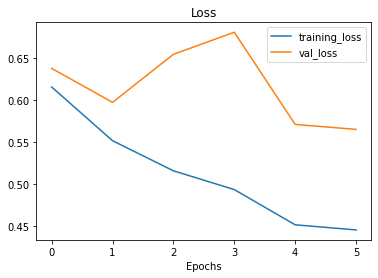

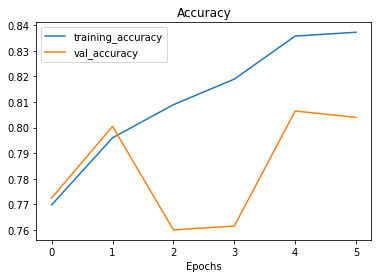

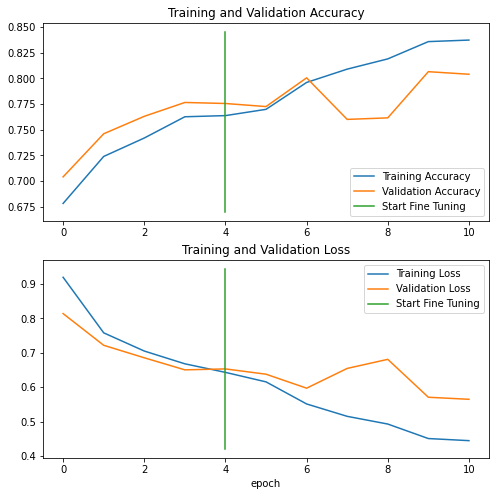

In [ ]:
history_b0_aug_finetune= train_model(model_b0_aug, train_data_aug, experiment_name="efficientnetB0_aug_finetune", EPOCHS=5, fine_tune=True)
plot_loss_curves(history_b0_aug_finetune)
compare_historys(history_b0_aug,
                 history_b0_aug_finetune,
                 initial_epochs=5)

#EfficientNetB1

In [ ]:
transfer_model= 'EfficientNetB1'
exec('base_model = tf.keras.applications.'+transfer_model+'(include_top=False)')
base_model.trainable = False
model_b1= create_model(img_shape=(300,400), num_class=7)

27018416/27018416 [==============================] - 0s 0us/step
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 300, 400, 3)]     0         
                                                                 
 efficientnetb1 (Functional)  (None, None, None, 1280)  6575239  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 7)                 8967      
                                                                 
Total params: 6,584,206
Trainable params: 8,967
Non-trainable params: 6,575,239
_________________________________________________________________
None


Saving TensorBoard log files to: /content/drive/MyDrive/tensor board log/ham10000_effi/efficientnetB1/20221121-004927
Epoch 1/5
251/251 [==============================] - 167s 632ms/step - loss: 0.8679 - accuracy: 0.6918 - val_loss: 0.7380 - val_accuracy: 0.7365 - lr: 0.0010
Epoch 2/5
251/251 [==============================] - 160s 638ms/step - loss: 0.7134 - accuracy: 0.7365 - val_loss: 0.6655 - val_accuracy: 0.7575 - lr: 0.0010
Epoch 3/5
251/251 [==============================] - 151s 600ms/step - loss: 0.6518 - accuracy: 0.7572 - val_loss: 0.6315 - val_accuracy: 0.7700 - lr: 0.0010
Epoch 4/5
251/251 [==============================] - 157s 623ms/step - loss: 0.6136 - accuracy: 0.7727 - val_loss: 0.6111 - val_accuracy: 0.7780 - lr: 0.0010
Epoch 5/5
251/251 [==============================] - 167s 665ms/step - loss: 0.5818 - accuracy: 0.7828 - val_loss: 0.5961 - val_accuracy: 0.7810 - lr: 0.0010


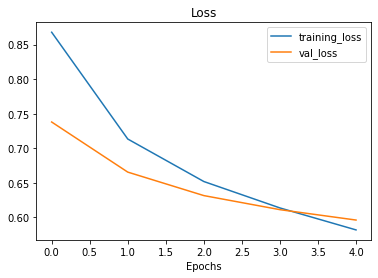

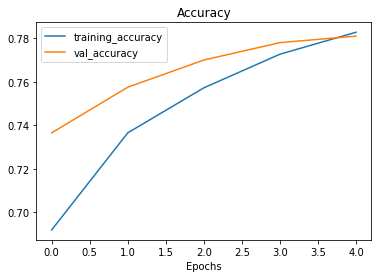

In [ ]:
history_b1= train_model(model_b1, train_data, experiment_name="efficientnetB1", EPOCHS=5)
plot_loss_curves(history_b1)

In [ ]:
unfreeze(model_b1, num_layers=10)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 300, 400, 3)]     0         
                                                                 
 efficientnetb1 (Functional)  (None, None, None, 1280)  6575239  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 7)                 8967      
                                                                 
Total params: 6,584,206
Trainable params: 1,345,367
Non-trainable params: 5,238,839
_________________________________________________________________
None


Saving TensorBoard log files to: /content/drive/MyDrive/tensor board log/ham10000_effi/efficientnetB1_finetune/20221121-012521
Epoch 5/10
251/251 [==============================] - 170s 643ms/step - loss: 0.5403 - accuracy: 0.7938 - val_loss: 0.5480 - val_accuracy: 0.8095 - lr: 1.0000e-04
Epoch 6/10
251/251 [==============================] - 167s 665ms/step - loss: 0.4751 - accuracy: 0.8243 - val_loss: 0.5159 - val_accuracy: 0.8190 - lr: 1.0000e-04
Epoch 7/10
251/251 [==============================] - 169s 671ms/step - loss: 0.4160 - accuracy: 0.8518 - val_loss: 0.4913 - val_accuracy: 0.8285 - lr: 1.0000e-04
Epoch 8/10
251/251 [==============================] - 165s 656ms/step - loss: 0.3778 - accuracy: 0.8634 - val_loss: 0.5007 - val_accuracy: 0.8240 - lr: 1.0000e-04
Epoch 9/10
251/251 [==============================] - ETA: 0s - loss: 0.3396 - accuracy: 0.8779
Epoch 9: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
251/251 [==============================] - 162s 6

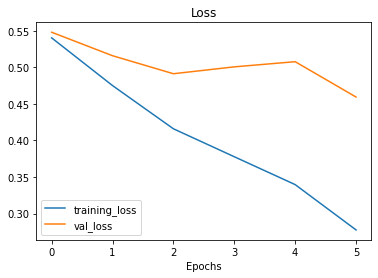

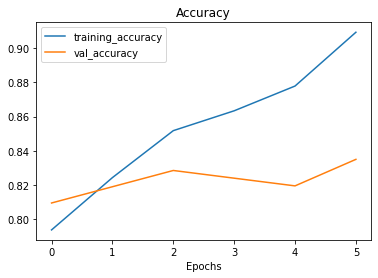

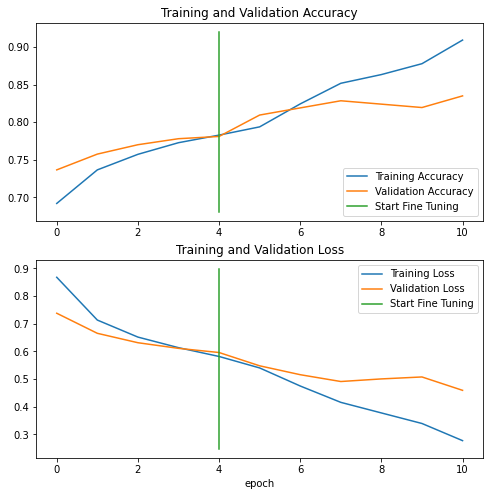

In [ ]:
history_b1_finetune= train_model(model_b1, train_data, experiment_name="efficientnetB1_finetune", EPOCHS=5, fine_tune=True)
plot_loss_curves(history_b1_finetune)
compare_historys(history_b1,
                 history_b1_finetune,
                 initial_epochs=5)

In [ ]:
transfer_model= 'EfficientNetB1'
exec('base_model = tf.keras.applications.'+transfer_model+'(include_top=False)')
base_model.trainable = False
model_b01_aug= create_model(img_shape=(300,400), num_class=7)

27018416/27018416 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 300, 400, 3)]     0         
                                                                 
 efficientnetb1 (Functional)  (None, None, None, 1280)  6575239  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 7)                 8967      
                                                                 
Total params: 6,584,206
Trainable params: 8,967
Non-trainable params: 6,575,239
_________________________________________________________________
None


Saving TensorBoard log files to: /content/drive/MyDrive/tensor board log/ham10000_effi/efficientnetB01_aug/20221121-214405
Epoch 1/5
251/251 [==============================] - 331s 1s/step - loss: 0.8703 - accuracy: 0.6925 - val_loss: 0.7963 - val_accuracy: 0.7145 - lr: 0.0010
Epoch 2/5
251/251 [==============================] - 280s 1s/step - loss: 0.7087 - accuracy: 0.7407 - val_loss: 0.7351 - val_accuracy: 0.7255 - lr: 0.0010
Epoch 3/5
251/251 [==============================] - 281s 1s/step - loss: 0.6473 - accuracy: 0.7646 - val_loss: 0.7027 - val_accuracy: 0.7330 - lr: 0.0010
Epoch 4/5
251/251 [==============================] - 278s 1s/step - loss: 0.6204 - accuracy: 0.7743 - val_loss: 0.6877 - val_accuracy: 0.7425 - lr: 0.0010
Epoch 5/5
251/251 [==============================] - 274s 1s/step - loss: 0.5973 - accuracy: 0.7813 - val_loss: 0.6784 - val_accuracy: 0.7415 - lr: 0.0010


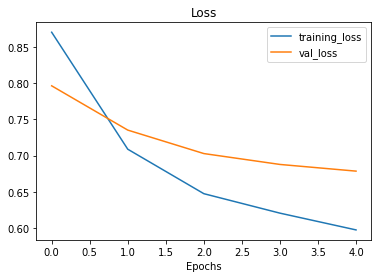

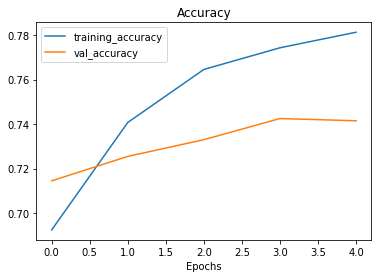

In [ ]:
history_b1_aug= train_model(model_b01_aug, train_data_aug, experiment_name="efficientnetB01_aug", EPOCHS=5)
plot_loss_curves(history_b1_aug)

In [ ]:
unfreeze(model_b01_aug, num_layers=10)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 300, 400, 3)]     0         
                                                                 
 efficientnetb1 (Functional)  (None, None, None, 1280)  6575239  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 7)                 8967      
                                                                 
Total params: 6,584,206
Trainable params: 1,345,367
Non-trainable params: 5,238,839
_________________________________________________________________
None


Saving TensorBoard log files to: /content/drive/MyDrive/tensor board log/ham10000_effi/efficientnetB1_aug_finetune/20221121-220955
Epoch 5/10
251/251 [==============================] - 290s 1s/step - loss: 0.5627 - accuracy: 0.7981 - val_loss: 0.6572 - val_accuracy: 0.7515 - lr: 1.0000e-04
Epoch 6/10
251/251 [==============================] - 280s 1s/step - loss: 0.5128 - accuracy: 0.8099 - val_loss: 0.6395 - val_accuracy: 0.7655 - lr: 1.0000e-04
Epoch 7/10
251/251 [==============================] - 279s 1s/step - loss: 0.4771 - accuracy: 0.8269 - val_loss: 0.6762 - val_accuracy: 0.7395 - lr: 1.0000e-04
Epoch 8/10
251/251 [==============================] - ETA: 0s - loss: 0.4493 - accuracy: 0.8364
Epoch 8: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
251/251 [==============================] - 279s 1s/step - loss: 0.4493 - accuracy: 0.8364 - val_loss: 0.6433 - val_accuracy: 0.7590 - lr: 1.0000e-04
Epoch 9/10
251/251 [==============================] - 277s 1s/step -

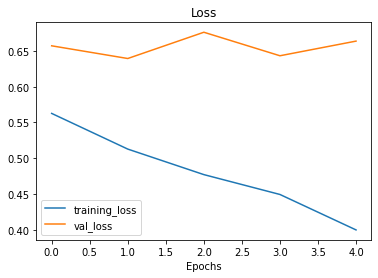

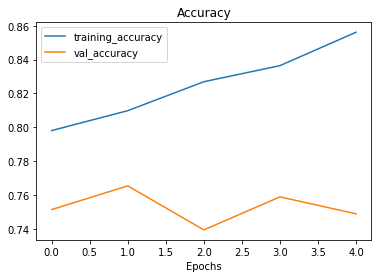

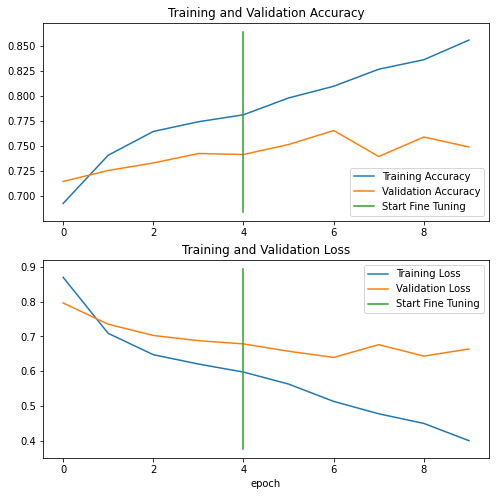

In [ ]:
history_b1_aug_finetune= train_model(model_b01_aug, train_data_aug, experiment_name="efficientnetB1_aug_finetune", EPOCHS=5, fine_tune=True)
plot_loss_curves(history_b1_aug_finetune)
compare_historys(history_b1_aug,
                 history_b1_aug_finetune,
                 initial_epochs=5)

#EfficientNetB2

In [ ]:
transfer_model= 'EfficientNetB2'
exec('base_model = tf.keras.applications.'+transfer_model+'(include_top=False)')
base_model.trainable = False
model_b2= create_model(img_shape=(300,400), num_class=7)

31790344/31790344 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 300, 400, 3)]     0         
                                                                 
 efficientnetb2 (Functional)  (None, None, None, 1408)  7768569  
                                                                 
 global_average_pooling (Glo  (None, 1408)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 7)                 9863      
                                                                 
Total params: 7,778,432
Trainable params: 9,863
Non-trainable params: 7,768,569
_________________________________________________________________
None


Saving TensorBoard log files to: /content/drive/MyDrive/tensor board log/ham10000_effi/efficientnetB2/20221121-132056
Epoch 1/5
251/251 [==============================] - 157s 561ms/step - loss: 0.8513 - accuracy: 0.6968 - val_loss: 0.7320 - val_accuracy: 0.7240 - lr: 0.0010
Epoch 2/5
251/251 [==============================] - 122s 487ms/step - loss: 0.6772 - accuracy: 0.7532 - val_loss: 0.6729 - val_accuracy: 0.7550 - lr: 0.0010
Epoch 3/5
251/251 [==============================] - 127s 506ms/step - loss: 0.6226 - accuracy: 0.7714 - val_loss: 0.6467 - val_accuracy: 0.7630 - lr: 0.0010
Epoch 4/5
251/251 [==============================] - 129s 513ms/step - loss: 0.5859 - accuracy: 0.7824 - val_loss: 0.6213 - val_accuracy: 0.7740 - lr: 0.0010
Epoch 5/5
251/251 [==============================] - 130s 517ms/step - loss: 0.5529 - accuracy: 0.7971 - val_loss: 0.5989 - val_accuracy: 0.7805 - lr: 0.0010


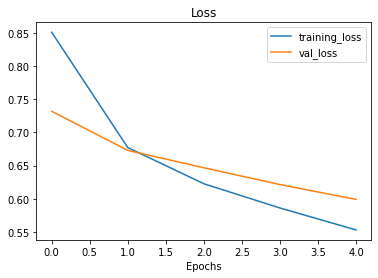

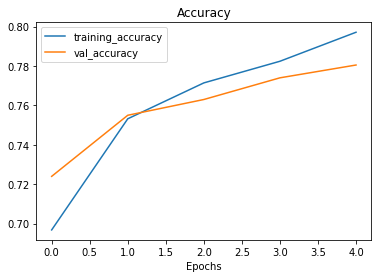

In [ ]:
history_b2= train_model(model_b2, train_data, experiment_name="efficientnetB2", EPOCHS=5)
plot_loss_curves(history_b2)

In [ ]:
unfreeze(model_b2, num_layers=10)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 300, 400, 3)]     0         
                                                                 
 efficientnetb2 (Functional)  (None, None, None, 1408)  7768569  
                                                                 
 global_average_pooling (Glo  (None, 1408)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 7)                 9863      
                                                                 
Total params: 7,778,432
Trainable params: 1,626,335
Non-trainable params: 6,152,097
_________________________________________________________________
None


Saving TensorBoard log files to: /content/drive/MyDrive/tensor board log/ham10000_effi/efficientnetB2_finetune/20221121-133307
Epoch 5/10
251/251 [==============================] - 154s 566ms/step - loss: 0.5250 - accuracy: 0.8091 - val_loss: 0.5553 - val_accuracy: 0.7985 - lr: 1.0000e-04
Epoch 6/10
251/251 [==============================] - 128s 509ms/step - loss: 0.4526 - accuracy: 0.8349 - val_loss: 0.5401 - val_accuracy: 0.8000 - lr: 1.0000e-04
Epoch 7/10
251/251 [==============================] - 127s 507ms/step - loss: 0.3943 - accuracy: 0.8533 - val_loss: 0.5111 - val_accuracy: 0.8135 - lr: 1.0000e-04
Epoch 8/10
251/251 [==============================] - 126s 503ms/step - loss: 0.3410 - accuracy: 0.8775 - val_loss: 0.5106 - val_accuracy: 0.8180 - lr: 1.0000e-04
Epoch 9/10
251/251 [==============================] - 126s 502ms/step - loss: 0.2992 - accuracy: 0.8932 - val_loss: 0.5076 - val_accuracy: 0.8160 - lr: 1.0000e-04
Epoch 10/10
251/251 [==============================] - 134

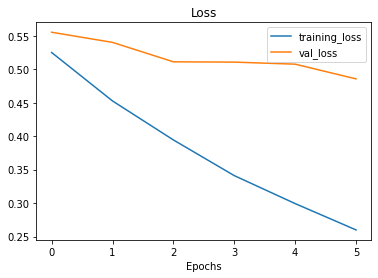

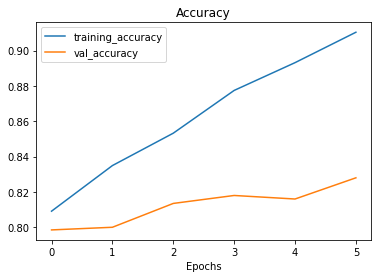

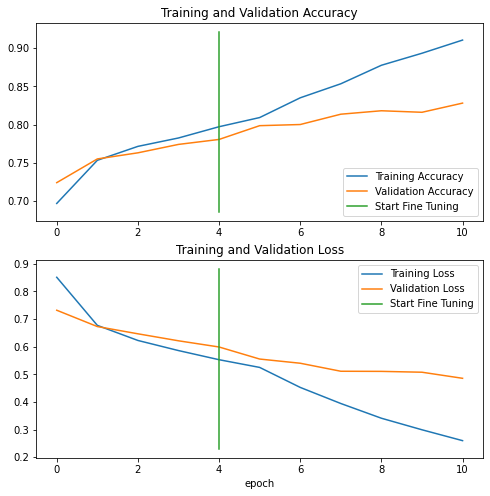

In [ ]:
history_b2_finetune= train_model(model_b2, train_data, experiment_name="efficientnetB2_finetune", EPOCHS=5, fine_tune=True)
plot_loss_curves(history_b2_finetune)
compare_historys(history_b2,
                 history_b2_finetune,
                 initial_epochs=5)

In [ ]:
transfer_model= 'EfficientNetB2'
exec('base_model = tf.keras.applications.'+transfer_model+'(include_top=False)')
base_model.trainable = False
model_b2_aug= create_model(img_shape=(300,400), num_class=7)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 300, 400, 3)]     0         
                                                                 
 efficientnetb2 (Functional)  (None, None, None, 1408)  7768569  
                                                                 
 global_average_pooling (Glo  (None, 1408)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 7)                 9863      
                                                                 
Total params: 7,778,432
Trainable params: 9,863
Non-trainable params: 7,768,569
_________________________________________________________________
None


Saving TensorBoard log files to: /content/drive/MyDrive/tensor board log/ham10000_effi/efficientnetB2_aug/20221121-141806
Epoch 1/5
251/251 [==============================] - 348s 1s/step - loss: 0.8778 - accuracy: 0.6942 - val_loss: 0.7891 - val_accuracy: 0.7105 - lr: 0.0010
Epoch 2/5
251/251 [==============================] - 312s 1s/step - loss: 0.7037 - accuracy: 0.7397 - val_loss: 0.7201 - val_accuracy: 0.7365 - lr: 0.0010
Epoch 3/5
251/251 [==============================] - 314s 1s/step - loss: 0.6542 - accuracy: 0.7644 - val_loss: 0.7218 - val_accuracy: 0.7450 - lr: 0.0010
Epoch 4/5
251/251 [==============================] - 322s 1s/step - loss: 0.6177 - accuracy: 0.7716 - val_loss: 0.6872 - val_accuracy: 0.7510 - lr: 0.0010
Epoch 5/5
251/251 [==============================] - 323s 1s/step - loss: 0.5936 - accuracy: 0.7825 - val_loss: 0.6543 - val_accuracy: 0.7610 - lr: 0.0010


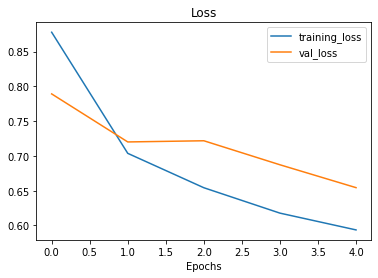

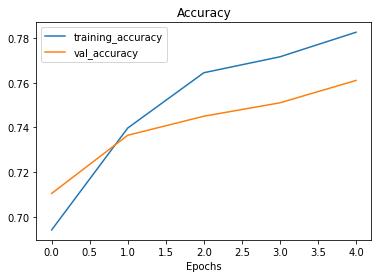

In [ ]:
history_b2_aug= train_model(model_b2_aug, train_data_aug, experiment_name="efficientnetB2_aug", EPOCHS=5)
plot_loss_curves(history_b2_aug)

In [ ]:
unfreeze(model_b2_aug, num_layers=10)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 300, 400, 3)]     0         
                                                                 
 efficientnetb2 (Functional)  (None, None, None, 1408)  7768569  
                                                                 
 global_average_pooling (Glo  (None, 1408)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 7)                 9863      
                                                                 
Total params: 7,778,432
Trainable params: 1,626,335
Non-trainable params: 6,152,097
_________________________________________________________________
None


Saving TensorBoard log files to: /content/drive/MyDrive/tensor board log/ham10000_effi/efficientnetB2_aug_finetune/20221121-144736
Epoch 5/10
251/251 [==============================] - 338s 1s/step - loss: 0.5656 - accuracy: 0.7915 - val_loss: 0.6728 - val_accuracy: 0.7465 - lr: 1.0000e-04
Epoch 6/10
251/251 [==============================] - 341s 1s/step - loss: 0.5087 - accuracy: 0.8115 - val_loss: 0.6532 - val_accuracy: 0.7605 - lr: 1.0000e-04
Epoch 7/10
251/251 [==============================] - 323s 1s/step - loss: 0.4810 - accuracy: 0.8226 - val_loss: 0.6110 - val_accuracy: 0.7730 - lr: 1.0000e-04
Epoch 8/10
251/251 [==============================] - 313s 1s/step - loss: 0.4437 - accuracy: 0.8334 - val_loss: 0.5585 - val_accuracy: 0.7920 - lr: 1.0000e-04
Epoch 9/10
251/251 [==============================] - 312s 1s/step - loss: 0.4180 - accuracy: 0.8442 - val_loss: 0.6006 - val_accuracy: 0.7785 - lr: 1.0000e-04
Epoch 10/10
251/251 [==============================] - 300s 1s/step -

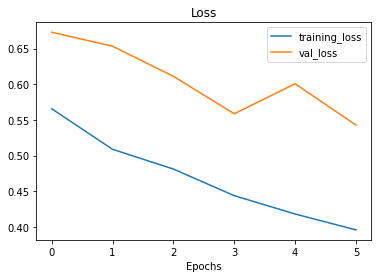

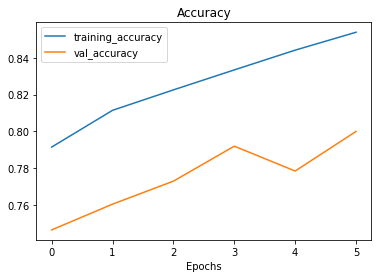

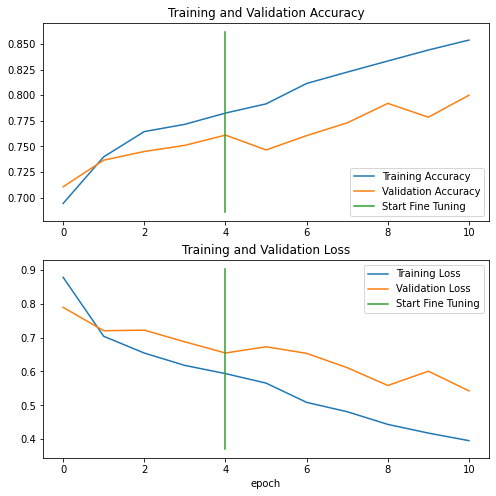

In [ ]:
history_b2_aug_finetune= train_model(model_b2_aug, train_data_aug, experiment_name="efficientnetB2_aug_finetune", EPOCHS=5, fine_tune=True)
plot_loss_curves(history_b2_aug_finetune)
compare_historys(history_b2_aug,
                 history_b2_aug_finetune,
                 initial_epochs=5)

#EfficientNetB3

In [ ]:
transfer_model= 'EfficientNetB3'
exec('base_model = tf.keras.applications.'+transfer_model+'(include_top=False)')
base_model.trainable = False
model_b3= create_model(img_shape=(300,400), num_class=7)

43941136/43941136 [==============================] - 0s 0us/step
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 300, 400, 3)]     0         
                                                                 
 efficientnetb3 (Functional)  (None, None, None, 1536)  10783535 
                                                                 
 global_average_pooling (Glo  (None, 1536)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 7)                 10759     
                                                                 
Total params: 10,794,294
Trainable params: 10,759
Non-trainable params: 10,783,535
_________________________________________________________________
None


Saving TensorBoard log files to: /content/drive/MyDrive/tensor board log/ham10000_effi/efficientnetB3/20221121-152131
Epoch 1/5
251/251 [==============================] - 139s 512ms/step - loss: 0.8483 - accuracy: 0.7068 - val_loss: 0.7570 - val_accuracy: 0.7235 - lr: 0.0010
Epoch 2/5
251/251 [==============================] - 119s 474ms/step - loss: 0.6929 - accuracy: 0.7492 - val_loss: 0.7096 - val_accuracy: 0.7370 - lr: 0.0010
Epoch 3/5
251/251 [==============================] - 136s 543ms/step - loss: 0.6386 - accuracy: 0.7668 - val_loss: 0.6833 - val_accuracy: 0.7480 - lr: 0.0010
Epoch 4/5
251/251 [==============================] - 119s 475ms/step - loss: 0.6058 - accuracy: 0.7757 - val_loss: 0.6496 - val_accuracy: 0.7660 - lr: 0.0010
Epoch 5/5
251/251 [==============================] - 118s 472ms/step - loss: 0.5739 - accuracy: 0.7888 - val_loss: 0.6529 - val_accuracy: 0.7640 - lr: 0.0010


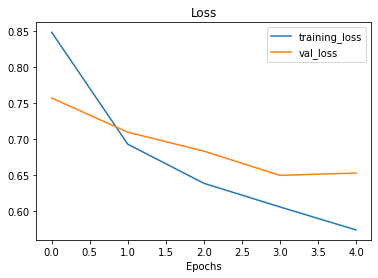

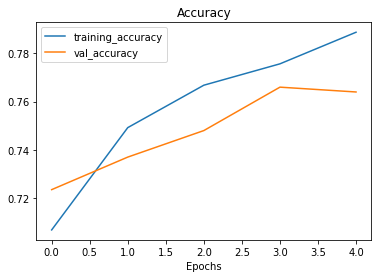

In [ ]:
history_b3= train_model(model_b3, train_data, experiment_name="efficientnetB3", EPOCHS=5)
plot_loss_curves(history_b3)

In [ ]:
unfreeze(model_b3, num_layers=10)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 300, 400, 3)]     0         
                                                                 
 efficientnetb3 (Functional)  (None, None, None, 1536)  10783535 
                                                                 
 global_average_pooling (Glo  (None, 1536)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 7)                 10759     
                                                                 
Total params: 10,794,294
Trainable params: 1,933,927
Non-trainable params: 8,860,367
_________________________________________________________________
None


Saving TensorBoard log files to: /content/drive/MyDrive/tensor board log/ham10000_effi/efficientnetB3_finetune/20221121-153335
Epoch 5/10
251/251 [==============================] - 133s 491ms/step - loss: 0.5468 - accuracy: 0.7980 - val_loss: 0.5963 - val_accuracy: 0.7885 - lr: 1.0000e-04
Epoch 6/10
251/251 [==============================] - 121s 481ms/step - loss: 0.4668 - accuracy: 0.8272 - val_loss: 0.5920 - val_accuracy: 0.7915 - lr: 1.0000e-04
Epoch 7/10
251/251 [==============================] - 121s 482ms/step - loss: 0.4061 - accuracy: 0.8512 - val_loss: 0.5816 - val_accuracy: 0.7960 - lr: 1.0000e-04
Epoch 8/10
251/251 [==============================] - 121s 482ms/step - loss: 0.3491 - accuracy: 0.8764 - val_loss: 0.5850 - val_accuracy: 0.8000 - lr: 1.0000e-04
Epoch 9/10
251/251 [==============================] - 124s 495ms/step - loss: 0.2988 - accuracy: 0.8958 - val_loss: 0.5791 - val_accuracy: 0.8000 - lr: 1.0000e-04
Epoch 10/10
251/251 [==============================] - 126

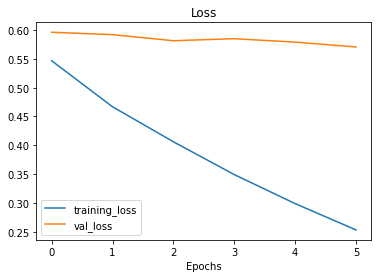

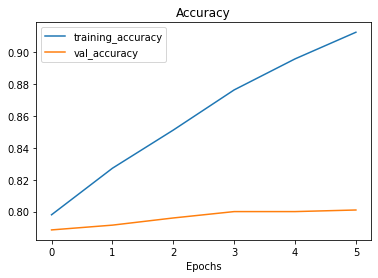

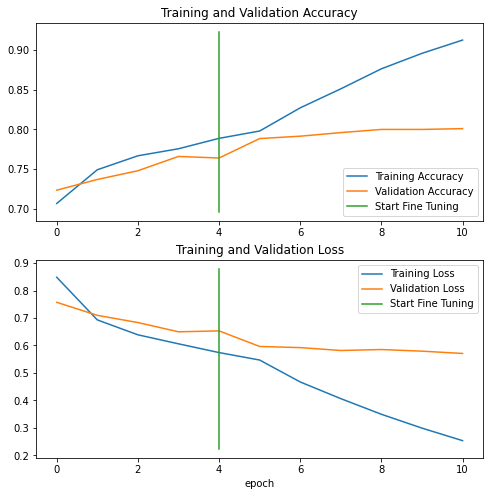

In [ ]:
history_b3_finetune= train_model(model_b3, train_data, experiment_name="efficientnetB3_finetune", EPOCHS=5, fine_tune=True)
plot_loss_curves(history_b3_finetune)
compare_historys(history_b3,
                 history_b3_finetune,
                 initial_epochs=5)

In [ ]:
transfer_model= 'EfficientNetB3'
exec('base_model = tf.keras.applications.'+transfer_model+'(include_top=False)')
base_model.trainable = False
model_b3_aug= create_model(img_shape=(300,400), num_class=7)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 300, 400, 3)]     0         
                                                                 
 efficientnetb3 (Functional)  (None, None, None, 1536)  10783535 
                                                                 
 global_average_pooling (Glo  (None, 1536)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 7)                 10759     
                                                                 
Total params: 10,794,294
Trainable params: 10,759
Non-trainable params: 10,783,535
_________________________________________________________________
None


Saving TensorBoard log files to: /content/drive/MyDrive/tensor board log/ham10000_effi/efficientnetB3_aug/20221121-154728
Epoch 1/5
251/251 [==============================] - 296s 1s/step - loss: 0.8700 - accuracy: 0.6963 - val_loss: 0.7872 - val_accuracy: 0.7175 - lr: 0.0010
Epoch 2/5
251/251 [==============================] - 279s 1s/step - loss: 0.7302 - accuracy: 0.7335 - val_loss: 0.7560 - val_accuracy: 0.7255 - lr: 0.0010
Epoch 3/5
251/251 [==============================] - 280s 1s/step - loss: 0.6794 - accuracy: 0.7515 - val_loss: 0.7164 - val_accuracy: 0.7390 - lr: 0.0010
Epoch 4/5
251/251 [==============================] - 281s 1s/step - loss: 0.6455 - accuracy: 0.7644 - val_loss: 0.6988 - val_accuracy: 0.7440 - lr: 0.0010
Epoch 5/5
251/251 [==============================] - 279s 1s/step - loss: 0.6308 - accuracy: 0.7692 - val_loss: 0.6924 - val_accuracy: 0.7455 - lr: 0.0010


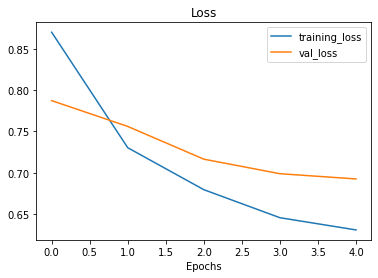

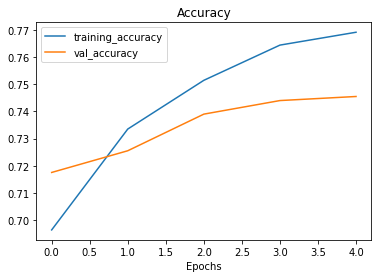

In [ ]:
history_b3_aug= train_model(model_b3_aug, train_data_aug, experiment_name="efficientnetB3_aug", EPOCHS=5)
plot_loss_curves(history_b3_aug)

In [ ]:
unfreeze(model_b3_aug, num_layers=10)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 300, 400, 3)]     0         
                                                                 
 efficientnetb3 (Functional)  (None, None, None, 1536)  10783535 
                                                                 
 global_average_pooling (Glo  (None, 1536)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 7)                 10759     
                                                                 
Total params: 10,794,294
Trainable params: 1,933,927
Non-trainable params: 8,860,367
_________________________________________________________________
None


Saving TensorBoard log files to: /content/drive/MyDrive/tensor board log/ham10000_effi/efficientnetB3_aug_finetune/20221121-161211
Epoch 5/10
251/251 [==============================] - 293s 1s/step - loss: 0.6039 - accuracy: 0.7793 - val_loss: 0.6640 - val_accuracy: 0.7545 - lr: 1.0000e-04
Epoch 6/10
251/251 [==============================] - 283s 1s/step - loss: 0.5442 - accuracy: 0.8014 - val_loss: 0.6743 - val_accuracy: 0.7505 - lr: 1.0000e-04
Epoch 7/10
251/251 [==============================] - 294s 1s/step - loss: 0.5076 - accuracy: 0.8119 - val_loss: 0.6477 - val_accuracy: 0.7710 - lr: 1.0000e-04
Epoch 8/10
251/251 [==============================] - 301s 1s/step - loss: 0.4758 - accuracy: 0.8221 - val_loss: 0.6746 - val_accuracy: 0.7470 - lr: 1.0000e-04
Epoch 9/10
251/251 [==============================] - ETA: 0s - loss: 0.4427 - accuracy: 0.8399
Epoch 9: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
251/251 [==============================] - 282s 1s/step -

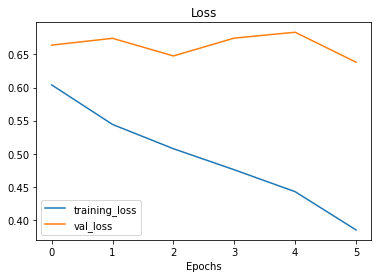

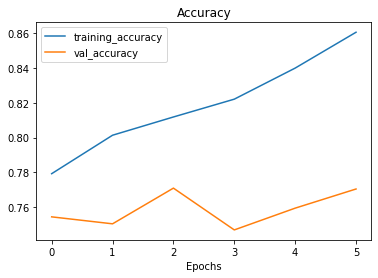

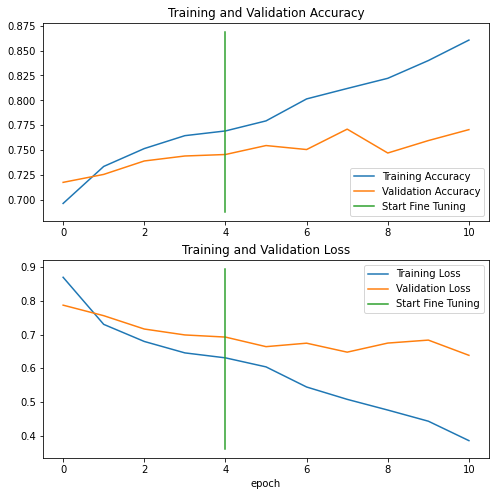

In [ ]:
history_b3_aug_finetune= train_model(model_b3_aug, train_data_aug, experiment_name="efficientnetB3_aug_finetune", EPOCHS=5, fine_tune=True)
plot_loss_curves(history_b3_aug_finetune)
compare_historys(history_b3_aug,
                 history_b3_aug_finetune,
                 initial_epochs=5)

#EfficientNetB4

In [ ]:
transfer_model= 'EfficientNetB4'
exec('base_model = tf.keras.applications.'+transfer_model+'(include_top=False)')
base_model.trainable = False
model_b4= create_model(img_shape=(300,400), num_class=7)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 300, 400, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, None, None, 1792)  17673823 
                                                                 
 global_average_pooling (Glo  (None, 1792)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 7)                 12551     
                                                                 
Total params: 17,686,374
Trainable params: 12,551
Non-trainable params: 17,673,823
_________________________________________________________________
None


Saving TensorBoard log files to: /content/drive/MyDrive/tensor board log/ham10000_effi/efficientnetB4/20221121-164424
Epoch 1/5
251/251 [==============================] - 143s 525ms/step - loss: 0.8556 - accuracy: 0.6991 - val_loss: 0.7443 - val_accuracy: 0.7360 - lr: 0.0010
Epoch 2/5
251/251 [==============================] - 143s 571ms/step - loss: 0.6837 - accuracy: 0.7511 - val_loss: 0.6773 - val_accuracy: 0.7520 - lr: 0.0010
Epoch 3/5
251/251 [==============================] - 127s 506ms/step - loss: 0.6284 - accuracy: 0.7666 - val_loss: 0.6497 - val_accuracy: 0.7665 - lr: 0.0010
Epoch 4/5
251/251 [==============================] - 126s 500ms/step - loss: 0.5982 - accuracy: 0.7824 - val_loss: 0.6349 - val_accuracy: 0.7705 - lr: 0.0010
Epoch 5/5
251/251 [==============================] - 126s 501ms/step - loss: 0.5691 - accuracy: 0.7918 - val_loss: 0.6422 - val_accuracy: 0.7575 - lr: 0.0010


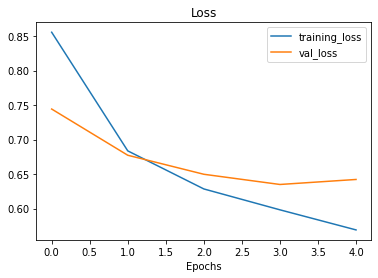

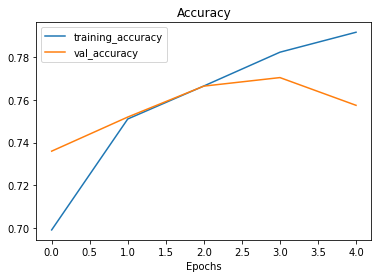

In [ ]:
history_b4= train_model(model_b4, train_data, experiment_name="efficientnetB4", EPOCHS=5)
plot_loss_curves(history_b4)

In [ ]:
unfreeze(model_b4, num_layers=10)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 300, 400, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, None, None, 1792)  17673823 
                                                                 
 global_average_pooling (Glo  (None, 1792)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 7)                 12551     
                                                                 
Total params: 17,686,374
Trainable params: 2,628,983
Non-trainable params: 15,057,391
_________________________________________________________________
None


Saving TensorBoard log files to: /content/drive/MyDrive/tensor board log/ham10000_effi/efficientnetB4_finetune/20221121-170405
Epoch 5/10
251/251 [==============================] - 152s 552ms/step - loss: 0.5513 - accuracy: 0.7965 - val_loss: 0.6002 - val_accuracy: 0.7775 - lr: 1.0000e-04
Epoch 6/10
251/251 [==============================] - 146s 580ms/step - loss: 0.4825 - accuracy: 0.8235 - val_loss: 0.5696 - val_accuracy: 0.7965 - lr: 1.0000e-04
Epoch 7/10
251/251 [==============================] - 129s 515ms/step - loss: 0.4207 - accuracy: 0.8484 - val_loss: 0.5545 - val_accuracy: 0.8060 - lr: 1.0000e-04
Epoch 8/10
251/251 [==============================] - 128s 511ms/step - loss: 0.3777 - accuracy: 0.8687 - val_loss: 0.5648 - val_accuracy: 0.7980 - lr: 1.0000e-04
Epoch 9/10
251/251 [==============================] - ETA: 0s - loss: 0.3232 - accuracy: 0.8877
Epoch 9: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
251/251 [==============================] - 128s 5

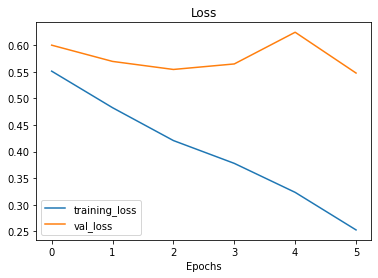

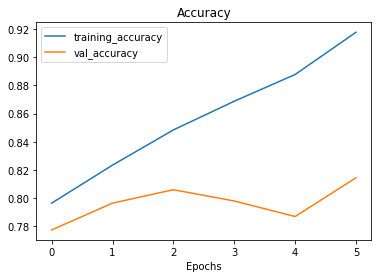

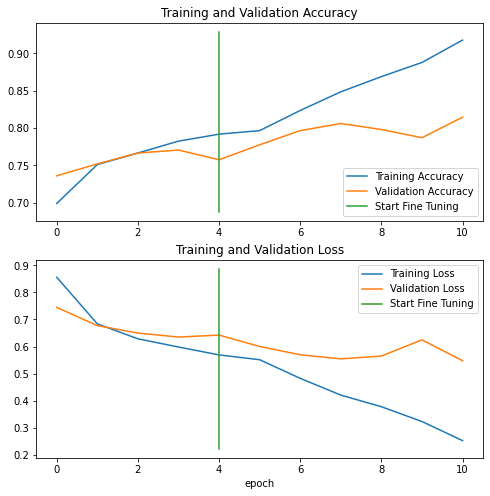

In [ ]:
history_b4_finetune= train_model(model_b4, train_data, experiment_name="efficientnetB4_finetune", EPOCHS=5, fine_tune=True)
plot_loss_curves(history_b4_finetune)
compare_historys(history_b4,
                 history_b4_finetune,
                 initial_epochs=5)

In [ ]:
transfer_model= 'EfficientNetB4'
exec('base_model = tf.keras.applications.'+transfer_model+'(include_top=False)')
base_model.trainable = False
model_b04_aug= create_model(img_shape=(300,400), num_class=7)

Saving TensorBoard log files to: /content/drive/MyDrive/tensor board log/ham10000_effi/efficientnetB4_aug/20221121-223425
Epoch 1/5
251/251 [==============================] - 310s 1s/step - loss: 0.8552 - accuracy: 0.6993 - val_loss: 0.8085 - val_accuracy: 0.7130 - lr: 0.0010
Epoch 2/5
251/251 [==============================] - 295s 1s/step - loss: 0.7026 - accuracy: 0.7420 - val_loss: 0.7375 - val_accuracy: 0.7185 - lr: 0.0010
Epoch 3/5
251/251 [==============================] - 292s 1s/step - loss: 0.6586 - accuracy: 0.7540 - val_loss: 0.6955 - val_accuracy: 0.7385 - lr: 0.0010
Epoch 4/5
251/251 [==============================] - 294s 1s/step - loss: 0.6250 - accuracy: 0.7706 - val_loss: 0.6883 - val_accuracy: 0.7580 - lr: 0.0010
Epoch 5/5
251/251 [==============================] - 294s 1s/step - loss: 0.6072 - accuracy: 0.7773 - val_loss: 0.6982 - val_accuracy: 0.7425 - lr: 0.0010


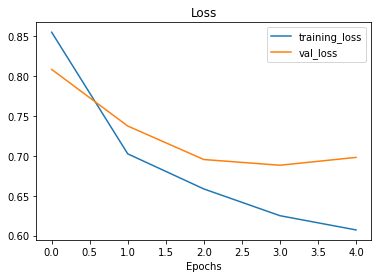

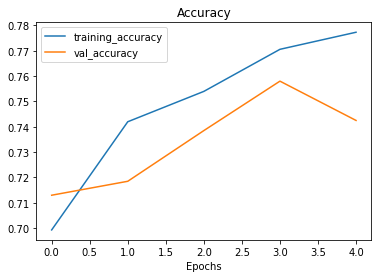

In [ ]:
history_b4_aug= train_model(model_b04_aug, train_data_aug, experiment_name="efficientnetB4_aug", EPOCHS=5)
plot_loss_curves(history_b4_aug)

In [ ]:
unfreeze(model_b04_aug, num_layers=10)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 300, 400, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, None, None, 1792)  17673823 
                                                                 
 global_average_pooling (Glo  (None, 1792)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 7)                 12551     
                                                                 
Total params: 17,686,374
Trainable params: 2,628,983
Non-trainable params: 15,057,391
_________________________________________________________________
None


Saving TensorBoard log files to: /content/drive/MyDrive/tensor board log/ham10000_effi/efficientnetB4_aug_finetune/20221121-230033
Epoch 5/10
251/251 [==============================] - 309s 1s/step - loss: 0.5948 - accuracy: 0.7819 - val_loss: 0.6570 - val_accuracy: 0.7465 - lr: 1.0000e-04
Epoch 6/10
251/251 [==============================] - 312s 1s/step - loss: 0.5523 - accuracy: 0.7989 - val_loss: 0.6337 - val_accuracy: 0.7645 - lr: 1.0000e-04
Epoch 7/10
251/251 [==============================] - 295s 1s/step - loss: 0.5154 - accuracy: 0.8052 - val_loss: 0.6267 - val_accuracy: 0.7570 - lr: 1.0000e-04
Epoch 8/10
251/251 [==============================] - 296s 1s/step - loss: 0.4965 - accuracy: 0.8148 - val_loss: 0.5864 - val_accuracy: 0.7835 - lr: 1.0000e-04
Epoch 9/10
251/251 [==============================] - 295s 1s/step - loss: 0.4661 - accuracy: 0.8289 - val_loss: 0.5923 - val_accuracy: 0.7805 - lr: 1.0000e-04
Epoch 10/10
251/251 [==============================] - 293s 1s/step -

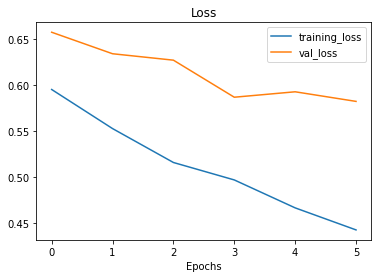

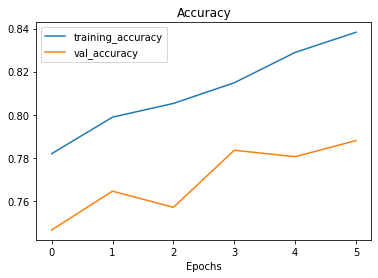

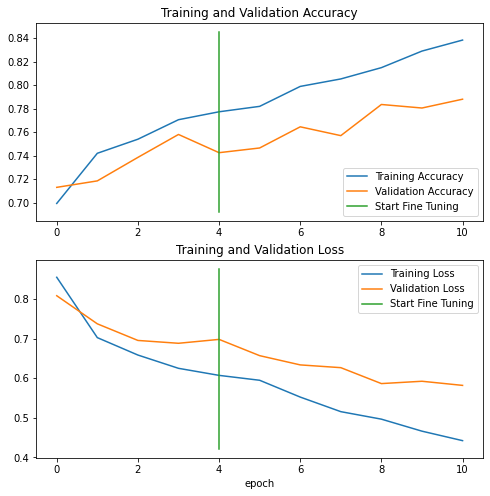

In [ ]:
history_b4_aug_finetune= train_model(model_b04_aug, train_data_aug, experiment_name="efficientnetB4_aug_finetune", EPOCHS=5, fine_tune=True)
plot_loss_curves(history_b4_aug_finetune)
compare_historys(history_b4_aug,
                 history_b4_aug_finetune,
                 initial_epochs=5)

#EfficientNetB5

In [ ]:
transfer_model= 'EfficientNetB5'
exec('base_model = tf.keras.applications.'+transfer_model+'(include_top=False)')
base_model.trainable = False
model_b5= create_model(img_shape=(300,400), num_class=7)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 300, 400, 3)]     0         
                                                                 
 efficientnetb5 (Functional)  (None, None, None, 2048)  28513527 
                                                                 
 global_average_pooling (Glo  (None, 2048)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 7)                 14343     
                                                                 
Total params: 28,527,870
Trainable params: 14,343
Non-trainable params: 28,513,527
_________________________________________________________________
None


Saving TensorBoard log files to: /content/drive/MyDrive/tensor board log/ham10000_effi/efficientnetB5/20221122-001810
Epoch 1/5
251/251 [==============================] - 192s 674ms/step - loss: 0.8134 - accuracy: 0.7169 - val_loss: 0.6963 - val_accuracy: 0.7495 - lr: 0.0010
Epoch 2/5
251/251 [==============================] - 153s 610ms/step - loss: 0.6534 - accuracy: 0.7662 - val_loss: 0.6492 - val_accuracy: 0.7650 - lr: 0.0010
Epoch 3/5
251/251 [==============================] - 153s 610ms/step - loss: 0.5998 - accuracy: 0.7854 - val_loss: 0.6234 - val_accuracy: 0.7685 - lr: 0.0010
Epoch 4/5
251/251 [==============================] - 153s 607ms/step - loss: 0.5697 - accuracy: 0.7956 - val_loss: 0.6171 - val_accuracy: 0.7665 - lr: 0.0010
Epoch 5/5
251/251 [==============================] - 153s 610ms/step - loss: 0.5411 - accuracy: 0.8044 - val_loss: 0.5896 - val_accuracy: 0.7810 - lr: 0.0010


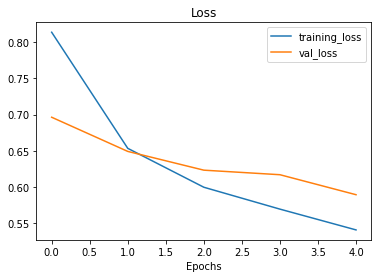

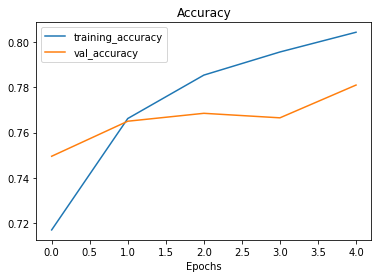

In [ ]:
history_b5= train_model(model_b5, train_data, experiment_name="efficientnetB5", EPOCHS=5)
plot_loss_curves(history_b5)

In [ ]:
unfreeze(model_b5, num_layers=10)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 300, 400, 3)]     0         
                                                                 
 efficientnetb5 (Functional)  (None, None, None, 2048)  28513527 
                                                                 
 global_average_pooling (Glo  (None, 2048)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 7)                 14343     
                                                                 
Total params: 28,527,870
Trainable params: 3,430,535
Non-trainable params: 25,097,335
_________________________________________________________________
None


Saving TensorBoard log files to: /content/drive/MyDrive/tensor board log/ham10000_effi/efficientnetB5_finetune/20221122-003441
Epoch 5/10
251/251 [==============================] - 200s 674ms/step - loss: 0.5230 - accuracy: 0.8107 - val_loss: 0.5530 - val_accuracy: 0.7985 - lr: 1.0000e-04
Epoch 6/10
251/251 [==============================] - 160s 638ms/step - loss: 0.4610 - accuracy: 0.8309 - val_loss: 0.5378 - val_accuracy: 0.8015 - lr: 1.0000e-04
Epoch 7/10
251/251 [==============================] - 158s 628ms/step - loss: 0.4146 - accuracy: 0.8492 - val_loss: 0.5458 - val_accuracy: 0.8040 - lr: 1.0000e-04
Epoch 8/10
251/251 [==============================] - 169s 671ms/step - loss: 0.3573 - accuracy: 0.8717 - val_loss: 0.5364 - val_accuracy: 0.7975 - lr: 1.0000e-04
Epoch 9/10
251/251 [==============================] - 158s 629ms/step - loss: 0.3073 - accuracy: 0.8922 - val_loss: 0.5488 - val_accuracy: 0.8050 - lr: 1.0000e-04
Epoch 10/10
251/251 [==============================] - 158

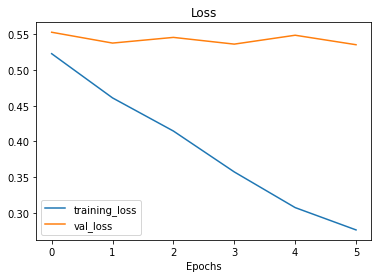

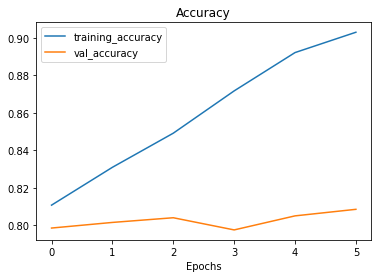

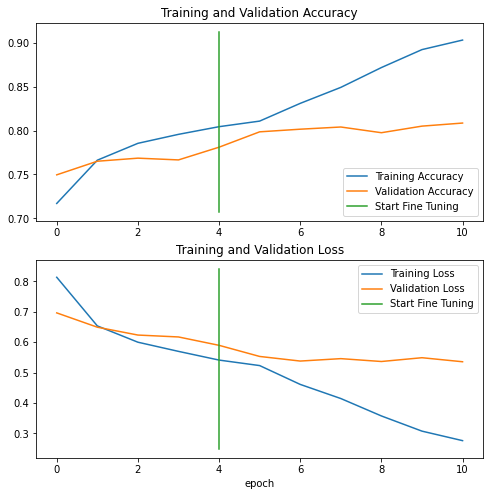

In [ ]:
history_b5_finetune= train_model(model_b5, train_data, experiment_name="efficientnetB5_finetune", EPOCHS=5, fine_tune=True)
plot_loss_curves(history_b5_finetune)
compare_historys(history_b5,
                 history_b5_finetune,
                 initial_epochs=5)

In [ ]:
transfer_model= 'EfficientNetB5'
exec('base_model = tf.keras.applications.'+transfer_model+'(include_top=False)')
base_model.trainable = False
model_b5_aug= create_model(img_shape=(300,400), num_class=7)

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 300, 400, 3)]     0         
                                                                 
 efficientnetb5 (Functional)  (None, None, None, 2048)  28513527 
                                                                 
 global_average_pooling (Glo  (None, 2048)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 7)                 14343     
                                                                 
Total params: 28,527,870
Trainable params: 14,343
Non-trainable params: 28,513,527
_________________________________________________________________
None


Saving TensorBoard log files to: /content/drive/MyDrive/tensor board log/ham10000_effi/efficientnetB5_aug/20221122-032126
Epoch 1/5
251/251 [==============================] - 212s 785ms/step - loss: 0.8295 - accuracy: 0.7093 - val_loss: 0.7907 - val_accuracy: 0.7135 - lr: 0.0010
Epoch 2/5
251/251 [==============================] - 194s 774ms/step - loss: 0.6873 - accuracy: 0.7520 - val_loss: 0.7343 - val_accuracy: 0.7300 - lr: 0.0010
Epoch 3/5
251/251 [==============================] - 194s 773ms/step - loss: 0.6470 - accuracy: 0.7651 - val_loss: 0.7004 - val_accuracy: 0.7360 - lr: 0.0010
Epoch 4/5
251/251 [==============================] - 194s 771ms/step - loss: 0.6216 - accuracy: 0.7742 - val_loss: 0.6937 - val_accuracy: 0.7355 - lr: 0.0010
Epoch 5/5
251/251 [==============================] - 195s 776ms/step - loss: 0.6021 - accuracy: 0.7808 - val_loss: 0.6786 - val_accuracy: 0.7440 - lr: 0.0010


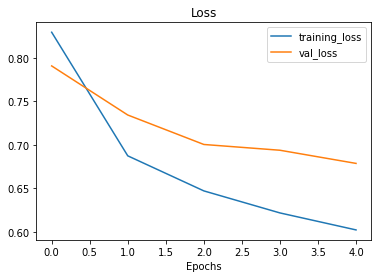

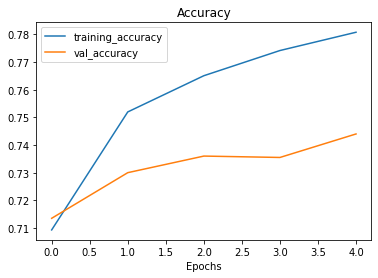

In [ ]:
history_b5_aug= train_model(model_b5_aug, train_data_aug, experiment_name="efficientnetB5_aug", EPOCHS=5)
plot_loss_curves(history_b5_aug)

In [ ]:
unfreeze(model_b5_aug, num_layers=10)

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 300, 400, 3)]     0         
                                                                 
 efficientnetb5 (Functional)  (None, None, None, 2048)  28513527 
                                                                 
 global_average_pooling (Glo  (None, 2048)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 7)                 14343     
                                                                 
Total params: 28,527,870
Trainable params: 3,430,535
Non-trainable params: 25,097,335
_________________________________________________________________
None


Saving TensorBoard log files to: /content/drive/MyDrive/tensor board log/ham10000_effi/efficientnetB5_aug_finetune/20221122-034129
Epoch 5/10
251/251 [==============================] - 235s 881ms/step - loss: 0.5867 - accuracy: 0.7859 - val_loss: 0.6610 - val_accuracy: 0.7580 - lr: 1.0000e-04
Epoch 6/10
251/251 [==============================] - 194s 771ms/step - loss: 0.5517 - accuracy: 0.7956 - val_loss: 0.6528 - val_accuracy: 0.7565 - lr: 1.0000e-04
Epoch 7/10
251/251 [==============================] - 193s 767ms/step - loss: 0.5236 - accuracy: 0.8057 - val_loss: 0.6428 - val_accuracy: 0.7645 - lr: 1.0000e-04
Epoch 8/10
251/251 [==============================] - 193s 768ms/step - loss: 0.5053 - accuracy: 0.8117 - val_loss: 0.6197 - val_accuracy: 0.7635 - lr: 1.0000e-04
Epoch 9/10
251/251 [==============================] - 192s 766ms/step - loss: 0.4929 - accuracy: 0.8156 - val_loss: 0.6709 - val_accuracy: 0.7445 - lr: 1.0000e-04
Epoch 10/10
251/251 [==============================] -

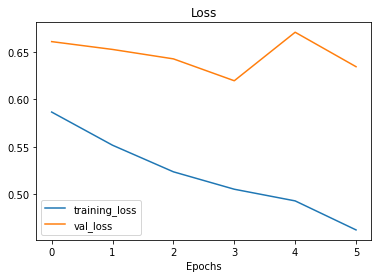

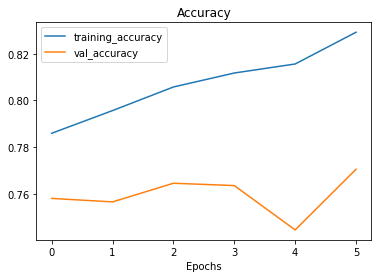

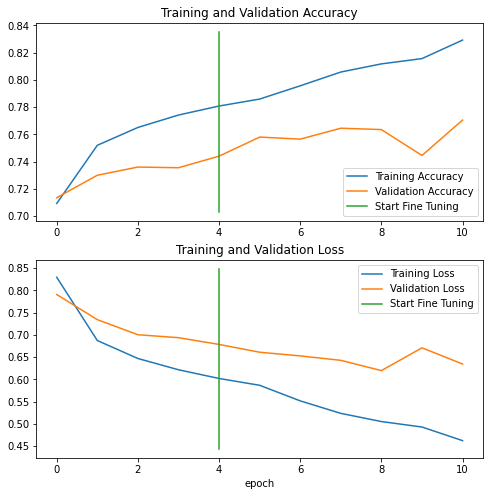

In [ ]:
history_b5_aug_finetune= train_model(model_b5_aug, train_data_aug, experiment_name="efficientnetB5_aug_finetune", EPOCHS=5, fine_tune=True)
plot_loss_curves(history_b5_aug_finetune)
compare_historys(history_b5_aug,
                 history_b5_aug_finetune,
                 initial_epochs=5)

#uploading the training logs to TensorBoard:

In [ ]:
!tensorboard dev upload --logdir '/content/drive/MyDrive/tensor board log/ham10000_effi' \
  --name "ham10000_efficientnet" \
  --description "transfer learning using efficientnet models to classify skin cancer images" \
  --one_shot

# Making the best model:

first let's load the data using `tf.keras.utils.image_dataset_from_directory` module.



In [ ]:
train_dir= '/content/ham10000/train'
test_dir= '/content/ham10000/test'

train_data= tf.keras.utils.image_dataset_from_directory(directory=train_dir,
                                                        labels='inferred',
                                                        label_mode='categorical' ,
                                                        class_names=class_names,
                                                        color_mode='rgb',
                                                        batch_size=32,
                                                        image_size=(450,600),
                                                        shuffle=True,
                                                        seed=32,
                                                        validation_split=None,
                                                        subset=None,
                                                        interpolation='bilinear',
                                                        follow_links=False,
                                                        crop_to_aspect_ratio=False)
test_data= tf.keras.utils.image_dataset_from_directory( directory=test_dir,
                                                        labels='inferred',
                                                        label_mode='categorical' ,
                                                        class_names=class_names,
                                                        color_mode='rgb',
                                                        batch_size=32,
                                                        image_size=(450,600),
                                                        shuffle=False,
                                                        seed=32,
                                                        validation_split=None,
                                                        subset=None,
                                                        interpolation='bilinear',
                                                        follow_links=False,
                                                        crop_to_aspect_ratio=False)

NameError: ignored

In [ ]:
base_model = tf.keras.applications.EfficientNetB1(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(450,600,3), name="input_layer") # shape of input image
x = inputs   
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(7, activation="softmax", name="output_layer")(x) # same number of outputs as classes
#model = tf.keras.Model(inputs, outputs)

model.compile(loss="categorical_crossentropy",
          optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
          metrics=["accuracy"])
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 450, 600, 3)]     0         
                                                                 
 efficientnetb1 (Functional)  (None, None, None, 1280)  6575239  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 7)                 8967      
                                                                 
Total params: 6,584,206
Trainable params: 8,967
Non-trainable params: 6,575,239
_________________________________________________________________
None


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1, 
                        mode='auto')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, 
                          verbose=1, mode='auto')
# Create checkpoint callback to save model for later use
checkpoint_path = "golden_model"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                        save_weights_only=True, # save only the model weights
                                                        monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                        save_best_only=True) # only keep the best model weights on file (delete the rest)

history = model.fit(train_data,
                    validation_data=test_data,
                    validation_steps= len(test_data),
                    epochs = 15,
                    callbacks = [reduce_lr,
                                early_stop,
                                create_tensorboard_callback(dir_name="/content/drive/MyDrive/tensor board log/ham10000_effi",experiment_name="golden_model"),
                                checkpoint_callback])

Saving TensorBoard log files to: /content/drive/MyDrive/tensor board log/ham10000_effi/golden_model/20221122-180425
Epoch 1/15
251/251 [==============================] - 158s 593ms/step - loss: 0.8674 - accuracy: 0.6979 - val_loss: 0.7513 - val_accuracy: 0.7250 - lr: 0.0010
Epoch 2/15
251/251 [==============================] - 147s 580ms/step - loss: 0.7089 - accuracy: 0.7367 - val_loss: 0.6836 - val_accuracy: 0.7485 - lr: 0.0010
Epoch 3/15
251/251 [==============================] - 149s 587ms/step - loss: 0.6479 - accuracy: 0.7608 - val_loss: 0.6517 - val_accuracy: 0.7600 - lr: 0.0010
Epoch 4/15
251/251 [==============================] - 147s 581ms/step - loss: 0.6077 - accuracy: 0.7777 - val_loss: 0.6297 - val_accuracy: 0.7630 - lr: 0.0010
Epoch 5/15
251/251 [==============================] - 147s 579ms/step - loss: 0.5808 - accuracy: 0.7844 - val_loss: 0.6094 - val_accuracy: 0.7760 - lr: 0.0010
Epoch 6/15
251/251 [==============================] - 146s 578ms/step - loss: 0.5550 - ac

In [ ]:
os.mkdir('/content/drive/MyDrive/models/ham1000'+'/'+'golden_model')
model.save('/content/drive/MyDrive/models/ham1000'+'/'+'golden_model'+'/'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

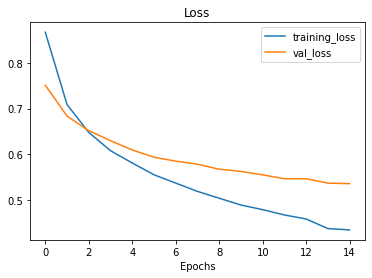

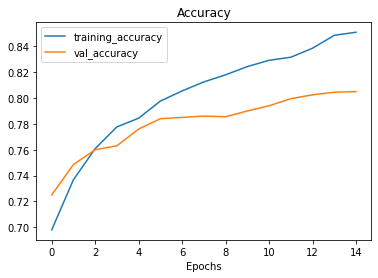

In [ ]:
plot_loss_curves(history)

In [ ]:
new_model= tf.keras.models.clone_model(model)
# Refreeze every layer except for the last 10
for layer in new_model.layers[1].layers: layer.trainable= False
for layer in new_model.layers[1].layers[-50:]: layer.trainable= True
new_model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=.0001), # use Adam with default settings
              metrics=["accuracy"])
new_model.set_weights(model.get_weights())
new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 450, 600, 3)]     0         
                                                                 
 efficientnetb1 (Functional)  (None, None, None, 1280)  6575239  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 7)                 8967      
                                                                 
Total params: 6,584,206
Trainable params: 3,511,479
Non-trainable params: 3,072,727
_________________________________________________________________


In [ ]:
# This function keeps the initial learning rate for the first ten epochs
# and decreases it exponentially after that.
def scheduler(epoch, lr):
  if epoch < 15:
    return lr
  else:
    return lr * .1

In [ ]:
history_finetune = new_model.fit(train_data,
                    validation_data=test_data,
                    validation_steps= len(test_data),
                    epochs = 18,
                    initial_epoch=14,
                    callbacks = [reduce_lr,
                                early_stop,
                                create_tensorboard_callback(dir_name="/content/drive/MyDrive/tensor board log/ham10000_effi",experiment_name="golden_model_finetune"),
                                checkpoint_callback,
                                tf.keras.callbacks.LearningRateScheduler(scheduler)])



Saving TensorBoard log files to: /content/drive/MyDrive/tensor board log/ham10000_effi/golden_model_finetune/20221122-205608
Epoch 15/18
251/251 [==============================] - 179s 671ms/step - loss: 0.4593 - accuracy: 0.8292 - val_loss: 0.4886 - val_accuracy: 0.8225 - lr: 1.0000e-04
Epoch 16/18
251/251 [==============================] - 169s 669ms/step - loss: 0.2851 - accuracy: 0.9018 - val_loss: 0.4450 - val_accuracy: 0.8390 - lr: 1.0000e-05
Epoch 17/18
251/251 [==============================] - 170s 670ms/step - loss: 0.2522 - accuracy: 0.9169 - val_loss: 0.4387 - val_accuracy: 0.8420 - lr: 1.0000e-06
Epoch 18/18
251/251 [==============================] - ETA: 0s - loss: 0.2470 - accuracy: 0.9177
Epoch 18: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.
251/251 [==============================] - 182s 721ms/step - loss: 0.2470 - accuracy: 0.9177 - val_loss: 0.4387 - val_accuracy: 0.8430 - lr: 1.0000e-08


In [ ]:
os.mkdir('/content/drive/MyDrive/models/ham1000'+'/'+'golden_model_finetune')
new_model.save('/content/drive/MyDrive/models/ham1000'+'/'+'golden_model_finetune'+'/'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

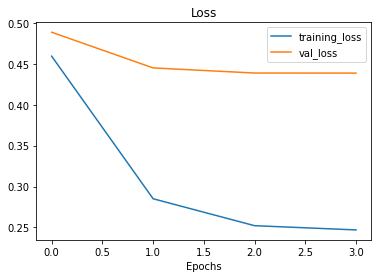

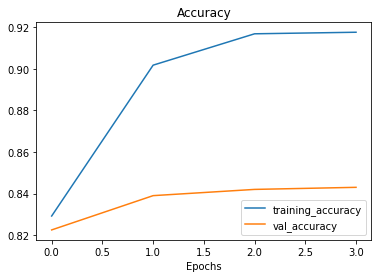

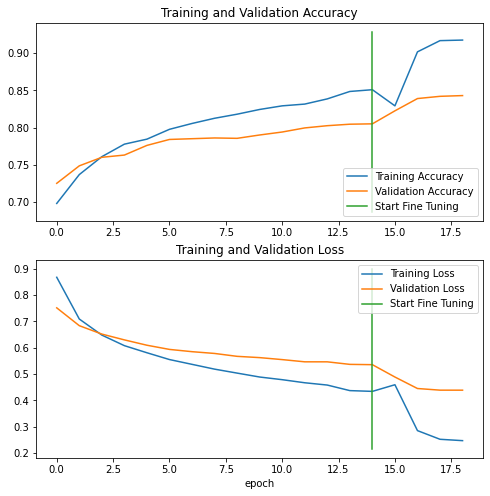

In [ ]:
plot_loss_curves(history_finetune)
compare_historys(history,
                 history_finetune,
                 initial_epochs=15)

In [ ]:
# Note: This might take a minute or so due to unravelling 790 batches
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
pred_classes= new_model.predict(test_data, verbose=1).argmax(axis=1).tolist()
pred_classes[:10]

63/63 [==============================] - 28s 453ms/step


[0, 5, 0, 0, 4, 5, 0, 0, 0, 0]

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))
class_names

              precision    recall  f1-score   support

           0       0.76      0.83      0.79        65
           1       0.85      0.85      0.85       102
           2       0.83      0.83      0.83       219
           3       0.86      0.78      0.82        23
           4       0.77      0.67      0.71       222
           5       0.94      0.97      0.96      1341
           6       1.00      0.82      0.90        28

    accuracy                           0.90      2000
   macro avg       0.86      0.82      0.84      2000
weighted avg       0.90      0.90      0.90      2000



['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [ ]:
# Note: This might take a minute or so due to unravelling 790 batches
y_labels = []
for images, labels in train_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
pred_classes= new_model.predict(train_data, verbose=1).argmax(axis=1).tolist()
pred_classes[:10]

251/251 [==============================] - 113s 450ms/step


[0, 0, 5, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))
class_names

              precision    recall  f1-score   support

           0       0.82      0.77      0.79       262
           1       0.85      0.84      0.85       412
           2       0.83      0.81      0.82       880
           3       0.85      0.63      0.72        92
           4       0.80      0.69      0.74       891
           5       0.94      0.97      0.95      5364
           6       0.97      0.91      0.94       114

    accuracy                           0.90      8015
   macro avg       0.87      0.80      0.83      8015
weighted avg       0.90      0.90      0.90      8015



['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [ ]:
pred_probs= pred_classes= new_model.predict(train_data, verbose=0)
pred_probs=pred_probs.max(axis=1)
pred_probs[:10]

array([0.85413027, 0.9997756 , 0.99835443, 0.63348997, 0.524123  ,
       0.92893374, 0.4878374 , 0.9995443 , 0.6827582 , 0.98171645],
      dtype=float32)

In [ ]:
pred_classes[:10]

array([[5.9284427e-04, 5.3079257e-04, 5.2258682e-02, 9.0799689e-02,
        1.0492378e-03, 8.5413027e-01, 6.3848123e-04],
       [7.6240489e-08, 9.4345225e-08, 1.2277106e-04, 9.1045265e-05,
        4.0343316e-06, 9.9977559e-01, 6.4934734e-06],
       [3.3582975e-08, 2.9709532e-05, 1.6078091e-04, 9.1493559e-05,
        1.7555869e-04, 9.9835443e-01, 1.1880465e-03],
       [4.0677257e-04, 1.1417152e-01, 6.3348997e-01, 3.1412163e-04,
        1.4158544e-01, 1.0986085e-01, 1.7127274e-04],
       [5.2412301e-01, 1.1938349e-01, 7.0124641e-02, 2.3209067e-01,
        2.7549932e-02, 2.6646752e-02, 8.1496561e-05],
       [1.4699918e-04, 3.1001847e-03, 9.2893374e-01, 2.0748109e-03,
        3.5151463e-02, 3.0289656e-02, 3.0318412e-04],
       [4.5552091e-03, 3.3617592e-01, 1.4873532e-02, 5.2527474e-05,
        1.5613852e-01, 4.8783740e-01, 3.6697128e-04],
       [1.1497565e-06, 5.8337326e-07, 6.4986707e-05, 3.6577939e-04,
        1.0734047e-05, 9.9954432e-01, 1.2450334e-05],
       [2.1140125e-04, 7

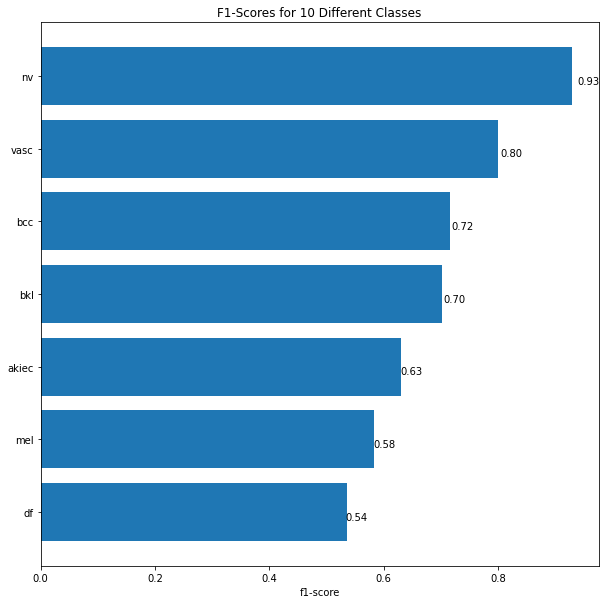

In [ ]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
fig, ax = plt.subplots(figsize=(10, 10))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects):
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

In [ ]:
# Create a function to import an image and resize it to be able to be used with our model
def load_image(filename, img_shape=(450,600), scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (450, 600, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img


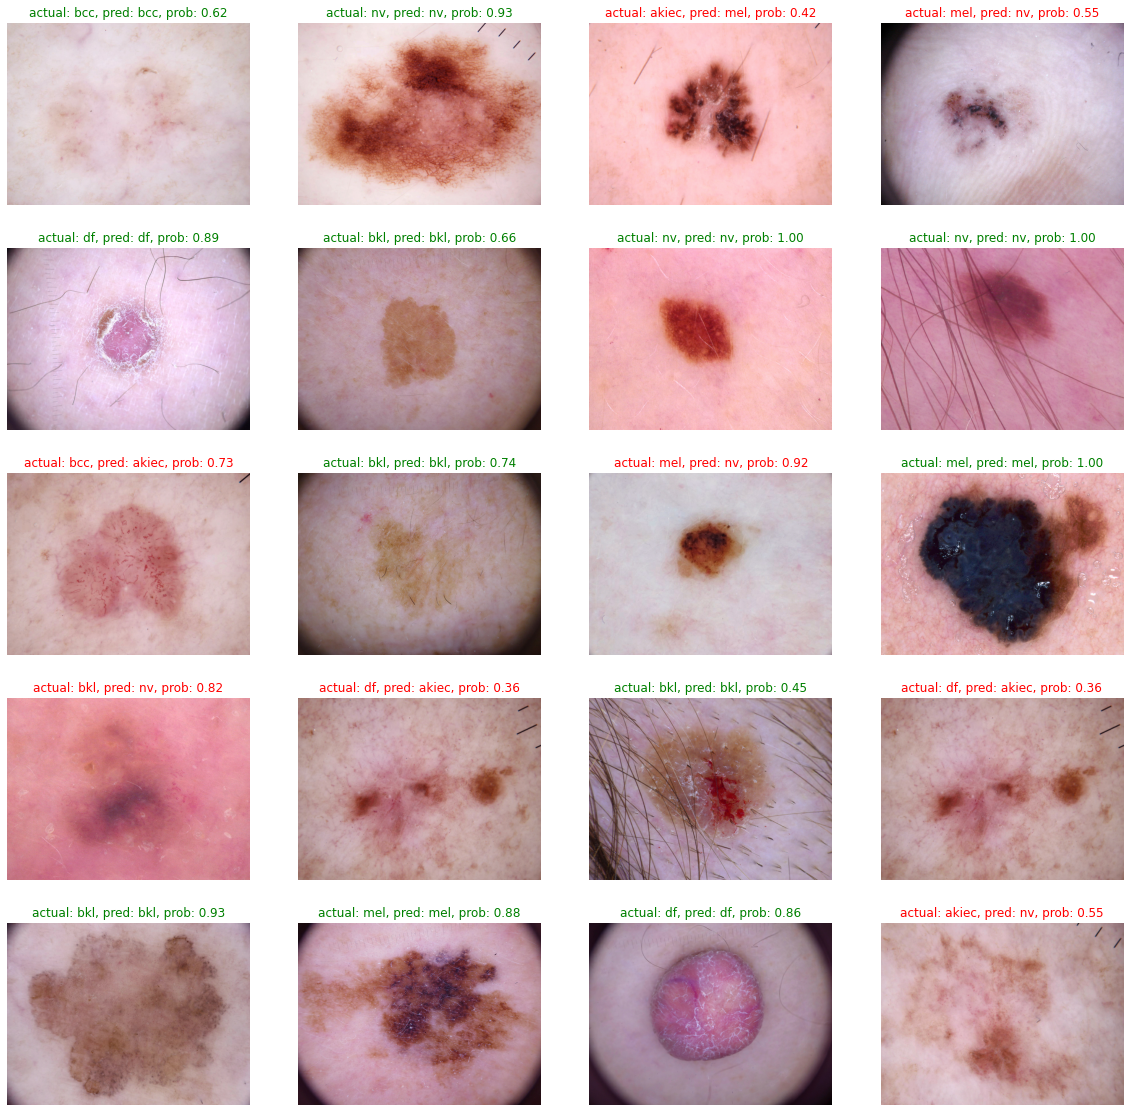

In [ ]:
# Make preds on a series of random images
import os
import random
test_dir= '/content/ham10000/test'
plt.figure(figsize=(20, 20))
for i in range(20):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir+'/' + class_name + "/" + filename

  # Load the image and make predictions
  img = load_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = new_model.predict(tf.expand_dims(img, axis=0), verbose=0) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(5, 4, i+1)
  plt.imshow(img.numpy()/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

In [ ]:
# 1. Get the filenames of all of our test data
filepaths = []
for filepath in test_data.list_files(test_dir+"/*/*.jpg", 
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

NameError: ignored

In [ ]:
# 2. Create a dataframe out of current prediction data for analysis
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes.argmax(axis=1),
                        "pred_conf": pred_probs, # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes.argmax(axis=1)]}) 
pred_df.head()

img_path  y_true  y_pred  \
0  b'/content/ham10000/test/akiec/ISIC_0024468.jpg'       0       0   
1  b'/content/ham10000/test/akiec/ISIC_0024579.jpg'       0       4   
2  b'/content/ham10000/test/akiec/ISIC_0024646.jpg'       0       2   
3  b'/content/ham10000/test/akiec/ISIC_0024923.jpg'       0       0   
4  b'/content/ham10000/test/akiec/ISIC_0025069.jpg'       0       0   

   pred_conf y_true_classname y_pred_classname  
0   0.975260            akiec            akiec  
1   0.422676            akiec              mel  
2   0.830618            akiec              bkl  
3   0.831022            akiec            akiec  
4   0.673652            akiec            akiec

In [ ]:
# 3. Is the prediction correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'/content/ham10000/test/akiec/ISIC_0024468.jpg'       0       0   
1  b'/content/ham10000/test/akiec/ISIC_0024579.jpg'       0       4   
2  b'/content/ham10000/test/akiec/ISIC_0024646.jpg'       0       2   
3  b'/content/ham10000/test/akiec/ISIC_0024923.jpg'       0       0   
4  b'/content/ham10000/test/akiec/ISIC_0025069.jpg'       0       0   

   pred_conf y_true_classname y_pred_classname  pred_correct  
0   0.975260            akiec            akiec          True  
1   0.422676            akiec              mel         False  
2   0.830618            akiec              bkl         False  
3   0.831022            akiec            akiec          True  
4   0.673652            akiec            akiec          True

In [ ]:
# 4. Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
487     b'/content/ham10000/test/mel/ISIC_0028760.jpg'       4       5   
40    b'/content/ham10000/test/akiec/ISIC_0029362.jpg'       0       1   
415     b'/content/ham10000/test/mel/ISIC_0024644.jpg'       4       2   
328     b'/content/ham10000/test/bkl/ISIC_0031253.jpg'       2       5   
560     b'/content/ham10000/test/mel/ISIC_0032653.jpg'       4       5   
1896     b'/content/ham10000/test/nv/ISIC_0033472.jpg'       5       4   
29    b'/content/ham10000/test/akiec/ISIC_0028132.jpg'       0       1   
432     b'/content/ham10000/test/mel/ISIC_0025313.jpg'       4       5   
1991   b'/content/ham10000/test/vasc/ISIC_0032270.jpg'       6       5   
809      b'/content/ham10000/test/nv/ISIC_0025689.jpg'       5       2   
567     b'/content/ham10000/test/mel/ISIC_0032812.jpg'       4       5   
520     b'/content/ham10000/test/mel/ISIC_0030747.jpg'       4       5   
623     b'/content/ham10000/test/mel/ISIC_0034205.jpg'       4       5   
517     b'/content/ham10000/test/mel/ISIC_0030575.jpg'       4       5   
273     b'/content/ham10000/test/bkl/ISIC_0028233.jpg'       2       1   
25    b'/content/ham10000/test/akiec/ISIC_0027303.jpg'       0       4   
484     b'/content/ham10000/test/mel/ISIC_0028579.jpg'       4       5   
595     b'/content/ham10000/test/mel/ISIC_0033405.jpg'       4       5   
589     b'/content/ham10000/test/mel/ISIC_0033336.jpg'       4       5   
333     b'/content/ham10000/test/bkl/ISIC_0031577.jpg'       2       5   

      pred_conf y_true_classname y_pred_classname  pred_correct  
487    0.999693              mel               nv         False  
40     0.993388            akiec              bcc         False  
415    0.987129              mel              bkl         False  
328    0.986259              bkl               nv         False  
560    0.982489              mel               nv         False  
1896   0.981667               nv              mel         False  
29     0.977232            akiec              bcc         False  
432    0.975590              mel               nv         False  
1991   0.974197             vasc               nv         False  
809    0.964852               nv              bkl         False  
567    0.964721              mel               nv         False  
520    0.963856              mel               nv         False  
623    0.957561              mel               nv         False  
517    0.955250              mel               nv         False  
273    0.947440              bkl              bcc         False  
25     0.946756            akiec              mel         False  
484    0.942790              mel               nv         False  
595    0.942770              mel               nv         False  
589    0.939471              mel               nv         False  
333    0.938475              bkl               nv         False

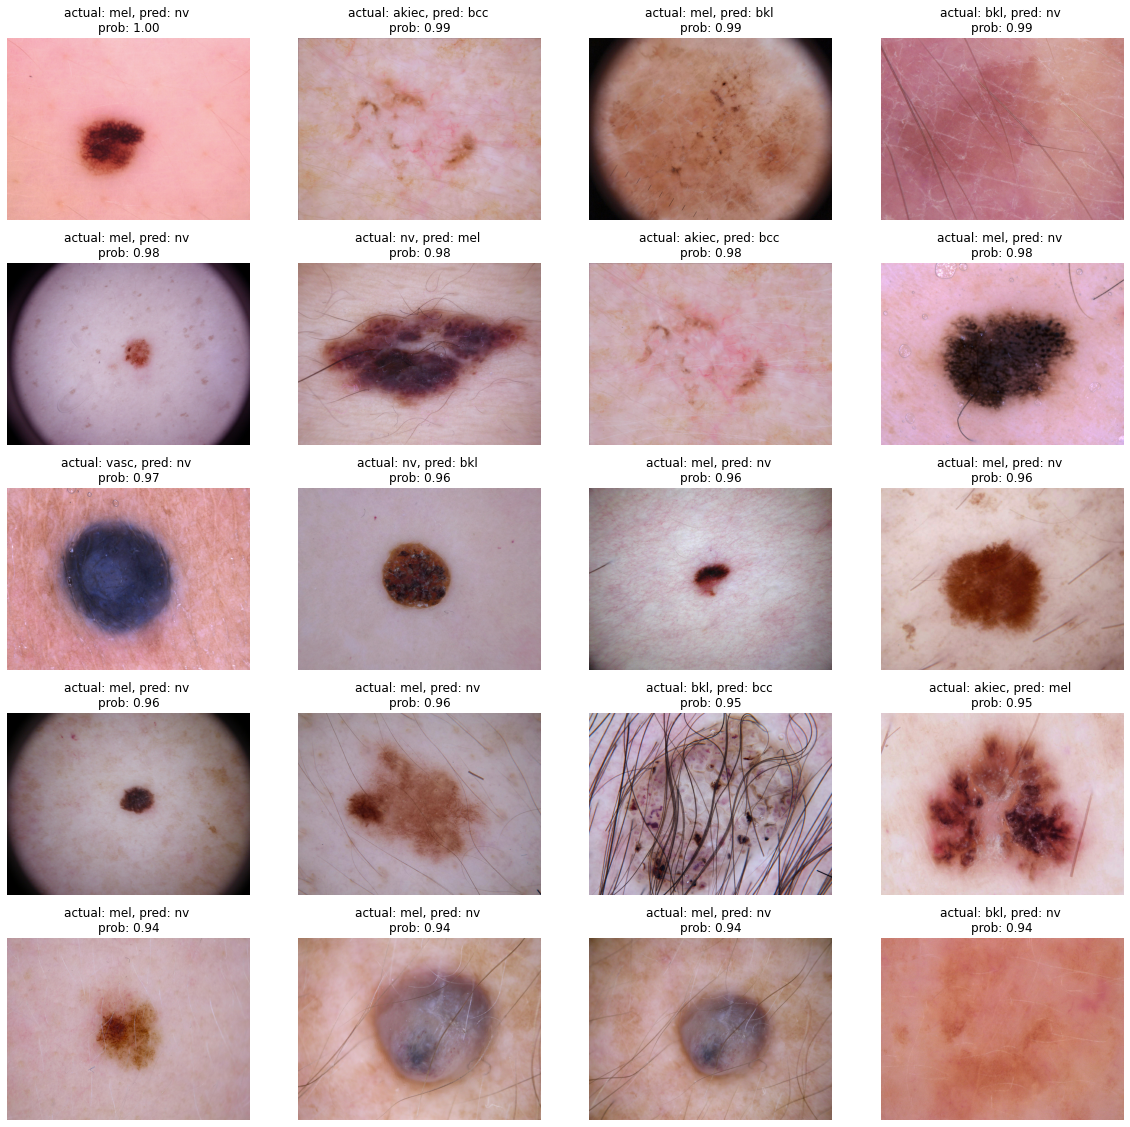

In [ ]:
# 5. Visualize some of the most wrong examples
images_to_view = 20
start_index = 0 # change the start index to view more
plt.figure(figsize=(20, 15))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(4, 5, i+1)
  img = load_image(row[1], scale=False)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img.numpy()/255.)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)
plt.savefig('datset.png', bbox_inches='tight', dpi=400)

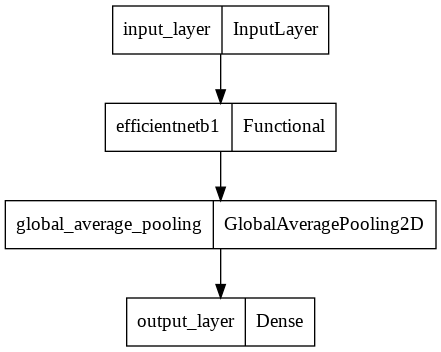

In [ ]:
import tensorflow as tf
new_model=tf.keras.models.load_model('/content/drive/MyDrive/models/ham1000/golden_model_finetune/20221122-211543')
tf.keras.utils.plot_model(new_model)

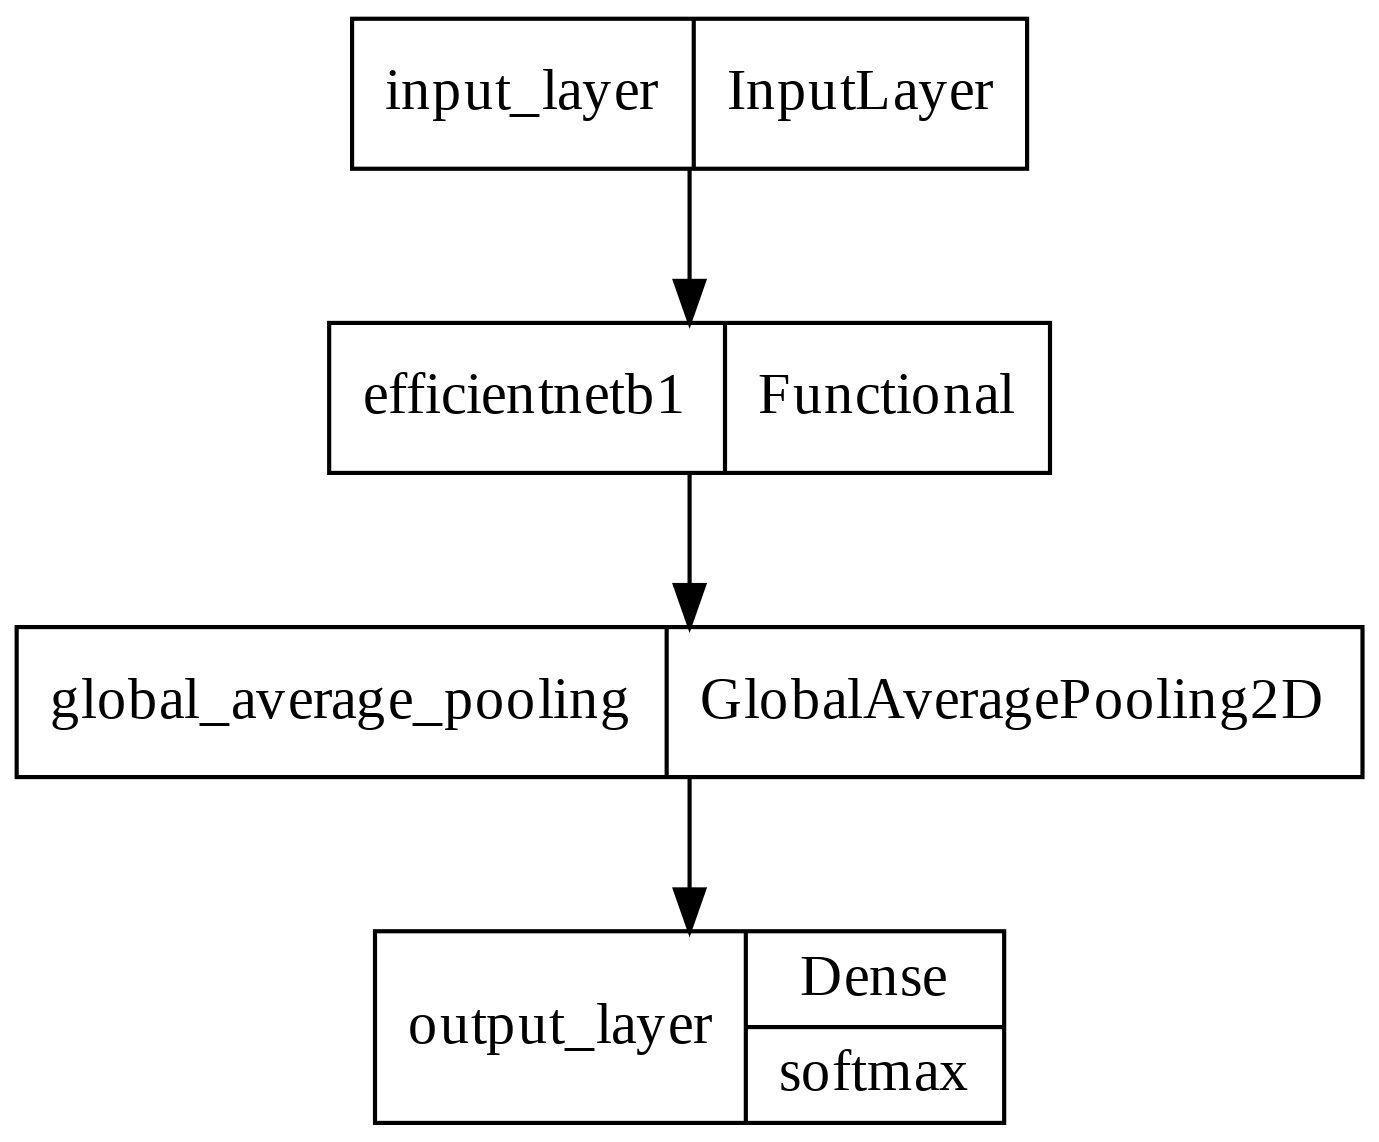

In [ ]:
    dot_img_file = 'model_arch.png'
    tf.keras.utils.plot_model(model, to_file=dot_img_file,show_layer_activations=True, expand_nested=False, dpi=300)